In [1]:
import os
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import precision_score, recall_score, f1_score

def active_learning(material, cube_numbers, cube_names):

    # Function to load dictionary from file
    def load_dictionary(file_path):
        with open(file_path, 'rb') as file:
            return pickle.load(file)

    base_path = f'./Data/Neuchatel_{material}/'
    cube_numbers_str = '_'.join(map(str, cube_numbers))

    file_name = f"{material}_cubes{cube_numbers_str}_feat.pkl"    
    file_path = os.path.join(base_path, file_name)

    data_base = load_dictionary(file_path)
    
    # Function to perform initial clustering and training
    def initial_clustering_and_training(data_base, power):
        print(f"Performing initial clustering for power: {power}")
        example = data_base[power]
        algorithm = SpectralClustering(n_clusters=2, random_state=1995)
        labels = algorithm.fit_predict(example)
        if labels[0] != 1:
            labels = 1 - labels
        speeds = example[:, -2] * 1800
        power_speed_pairs = np.column_stack((np.full(speeds.shape, power), speeds))
        print(f"Clustering completed for power: {power}")
        return power_speed_pairs, labels

    # Function to train surrogate model using Gaussian Process
    def train_surrogate_model(X, y):
        rbf_kernel = C(1.0) * RBF(length_scale=[10.61, 353.55])
        gp_model = GaussianProcessClassifier(kernel=rbf_kernel, random_state=1995)
        gp_model.fit(X, y)
        print("Gaussian Process model training completed.")
        return gp_model

    # Function to predict labels with uncertainty using GP
    def predict_with_uncertainty(gp_model, X):
        probs = gp_model.predict_proba(X)
        uncertainties = 1 - np.max(probs, axis=1)
        return probs, uncertainties

    # Function to compute evaluation metrics against ground truth
    def compute_metrics(pred_labels, ground_truth):
        gt_labels = ground_truth['Labels']
        precision = precision_score(gt_labels, pred_labels)
        recall = recall_score(gt_labels, pred_labels)
        f1 = f1_score(gt_labels, pred_labels)
        return precision, recall, f1

    # Function to find next power based on uncertainty
    def find_next_power(gp_model, all_powers, explored_powers, speeds):
        unexplored_powers = [p for p in all_powers if p not in explored_powers]
        uncertainties = []

        for power in unexplored_powers:
            test_data = np.array([[power, speed] for speed in speeds])
            _, uncertainty = predict_with_uncertainty(gp_model, test_data)
            uncertainties.append((power, np.mean(uncertainty)))

        next_power = max(uncertainties, key=lambda x: x[1])[0]
        print(f"Next power selected based on uncertainty: {next_power}")
        return next_power

    def plot_processing_maps(gt_data, pred_labels, gt_labels, title_pred, title_gt, fine_preds, fine_uncertainties):
        colors_pred = np.where(pred_labels == 1, 'red', 'green')
        colors_gt = np.where(gt_labels == 1, 'red', 'green')
        speeds = gt_data[:, 1]
        powers = gt_data[:, 0]

        fig, axes = plt.subplots(1, 4, figsize=(36, 8))

        # Predictions plot
        axes[0].scatter(speeds, powers, c=colors_pred, s=200)
        axes[0].scatter([], [], c='red', label='Keyhole')
        axes[0].scatter([], [], c='green', label='Conduction')
        legend = axes[0].legend(loc='lower right', bbox_to_anchor=(1, 0), 
                                scatterpoints=1, markerscale=2, prop={'size': 16})
        axes[0].set_title(title_pred)
        axes[0].set_xlabel('Speed (mm/s)')
        axes[0].set_ylabel('Power (W)')
        axes[0].grid()
        axes[0].set_xlim(80, 2000)
        axes[0].set_ylim(80, 130)

        # Ground truth plot
        axes[1].scatter(speeds, powers, c=colors_gt, s=200)
        axes[1].scatter([], [], c='red', label='Keyhole')
        axes[1].scatter([], [], c='green', label='Conduction')
        legend = axes[1].legend(loc='lower right', bbox_to_anchor=(1, 0), 
                                scatterpoints=1, markerscale=2, prop={'size': 16})
        axes[1].set_title(title_gt)
        axes[1].set_xlabel('Speed (mm/s)')
        axes[1].set_ylabel('Power (W)')
        axes[1].grid()
        axes[1].set_xlim(80, 2000)
        axes[1].set_ylim(80, 130)

        # Fine grid predictions heatmap
        im = axes[2].imshow(fine_preds.reshape(51, 1921), 
                            aspect='auto', extent=[80, 2000, 80, 130], 
                            origin='lower', cmap='viridis',
                            vmin=0, vmax=1)
        fig.colorbar(im, ax=axes[2])
        axes[2].scatter(speeds, powers, c=colors_pred, edgecolor='k', s=200)  # Overlay predictions
        axes[2].scatter([], [], c='red', label='Keyhole')
        axes[2].scatter([], [], c='green', label='Conduction')
        legend = axes[2].legend(loc='lower right', bbox_to_anchor=(1, 0), 
                                scatterpoints=1, markerscale=2, prop={'size': 16})
        axes[2].set_title('GP Predictions Heatmap')
        axes[2].set_xlabel('Speed (mm/s)')
        axes[2].set_ylabel('Power (W)')
        axes[2].grid()
        axes[2].set_xlim(80, 2000)
        axes[2].set_ylim(80, 130)

        # Uncertainty heatmap
        im = axes[3].imshow(fine_uncertainties.reshape(51, 1921), 
                            aspect='auto', extent=[80, 2000, 80, 130], 
                            origin='lower', cmap='plasma')
        fig.colorbar(im, ax=axes[3])
        axes[3].set_title('GP Uncertainty Heatmap')
        axes[3].set_xlabel('Speed (mm/s)')
        axes[3].set_ylabel('Power (W)')
        axes[3].grid()
        axes[3].set_xlim(80, 2000)
        axes[3].set_ylim(80, 130)

        plt.show()

    # New function to create and save the aggregate figure
    def create_aggregate_figure(all_plots, material, explored_powers, cube_names):
        print(material)
        if material == 'Ti64':
            material = 'Ti-6Al-4V'
        rows = len(all_plots)
        fig, axes = plt.subplots(rows, 3, figsize=(12*3, 12 * rows))
        fig.suptitle(f'Evolution of Processing Map Estimation for Cuboid {cube_names} ({material})', fontsize=35)
        plt.subplots_adjust(hspace=0.4)

        for i, (gt_data, pred_labels, gt_labels, fine_preds, fine_uncertainties) in enumerate(all_plots):
            colors_pred = np.where(pred_labels == 1, 'red', 'green')
            colors_gt = np.where(gt_labels == 1, 'red', 'green')
            speeds = gt_data[:, 1]
            powers = gt_data[:, 0]

            # Add subtitle for each row
            if i == 0:
                row_title = "Initial State (No Sampling)"
            elif i == 1:
                row_title = f"Power Sampled: {explored_powers[0]} W"
            else:
                row_title = f"Power Sampled: {explored_powers[i-1]} W"
#             fig.text(0.5, 1 - (i / rows) - 0.02, row_title, ha='center', va='bottom', fontsize=24, fontweight='bold')


            font_size = 30

            # Ground truth plot
            axes[i, 0].scatter(speeds, powers, c=colors_gt, s=500)
            axes[i, 0].scatter([], [], c='red', label='Keyhole')
            axes[i, 0].scatter([], [], c='green', label='Conduction')
            axes[i, 0].legend(loc='lower right', bbox_to_anchor=(1, 0), scatterpoints=1, markerscale=3, prop={'size': 30})
            axes[i, 0].set_title('Ground Truth', fontsize=font_size)
            axes[i, 0].set_xlabel('Speed (mm/s)', fontsize=font_size)
            axes[i, 0].set_ylabel('Power (W)', fontsize=font_size)
            axes[i, 0].grid()
            axes[i, 0].set_xlim(80, 2000)
            axes[i, 0].set_ylim(80, 130)
            axes[i, 0].tick_params(axis='both', which='major', labelsize=font_size)

            # Fine grid predictions heatmap
            im = axes[i, 1].imshow(fine_preds.reshape(51, 1921), 
                                aspect='auto', extent=[80, 2000, 80, 130], 
                                origin='lower', cmap='viridis',
                                vmin=0, vmax=1)
            cbar = fig.colorbar(im, ax=axes[i, 1])
            cbar.ax.tick_params(labelsize=20)
            axes[i, 1].scatter(speeds, powers, c=colors_pred, edgecolor='k', s=500)
            axes[i, 1].scatter([], [], c='red', label='Keyhole')
            axes[i, 1].scatter([], [], c='green', label='Conduction')
            axes[i, 1].legend(loc='lower right', bbox_to_anchor=(1, 0), scatterpoints=1, markerscale=3, prop={'size': 30})
            axes[i, 1].set_title(f'GP Predictions Heatmap\n{row_title}', fontsize=font_size)
            axes[i, 1].set_xlabel('Speed (mm/s)', fontsize=font_size)
            axes[i, 1].set_ylabel('Power (W)', fontsize=font_size)
            axes[i, 1].grid()
            axes[i, 1].set_xlim(80, 2000)
            axes[i, 1].set_ylim(80, 130)
            axes[i, 1].tick_params(axis='both', which='major', labelsize=font_size)

            # Uncertainty heatmap
            im = axes[i, 2].imshow(fine_uncertainties.reshape(51, 1921), 
                                aspect='auto', extent=[80, 2000, 80, 130], 
                                origin='lower', cmap='plasma',
                                vmin=0.1, vmax=0.5)
            cbar = fig.colorbar(im, ax=axes[i, 2])
            cbar.ax.tick_params(labelsize=16)
            axes[i, 2].set_title(f'GP Uncertainty Heatmap\n{row_title}', fontsize=font_size)
            axes[i, 2].set_xlabel('Speed (mm/s)', fontsize=font_size)
            axes[i, 2].set_ylabel('Power (W)', fontsize=font_size)
            axes[i, 2].grid()
            axes[i, 2].set_xlim(80, 2000)
            axes[i, 2].set_ylim(80, 130)
            axes[i, 2].tick_params(axis='both', which='major', labelsize=font_size)

        plt.tight_layout() #rect=[0, 0.03, 1, 0.95]plt.subplots_adjust(top=0.9)
        plt.subplots_adjust(top=0.95)
        plt.savefig(f'./Figures/aggregate_plot_{material}_{cube_names}.pdf', format='pdf', dpi=300, bbox_inches='tight')
        #plt.close()

    # Initial call to plot_processing_maps before sampling any data
    # Setting all predictions and uncertainties to 1
    initial_gt_data = np.array(list(zip(data_base['GT']['Powers'], data_base['GT']['Speeds'])))
    initial_pred_labels = np.ones(initial_gt_data.shape[0])
    initial_fine_preds = np.ones(51 * 1921)
    initial_fine_uncertainties = np.ones(51 * 1921)*0.5

    plot_processing_maps(initial_gt_data, initial_pred_labels, np.array(data_base['GT']['Labels']), 
                         'Initial State - GP Predictions for All Powers', 'Ground Truth for All Powers', 
                         initial_fine_preds, initial_fine_uncertainties)

    # Initialize with a random power
    powers = [k for k in data_base.keys() if k != 'GT']
    initial_power = random.choice(powers)
    print(f"Initial power selected: {initial_power}")
    power_speed_pairs, labels = initial_clustering_and_training(data_base, initial_power)

    # Train initial GP model
    gp_model = train_surrogate_model(power_speed_pairs, labels)

    # Predict on all (power, speed) pairs in ground truth
    gt_data = np.array(list(zip(data_base['GT']['Powers'], data_base['GT']['Speeds'])))
    pred_probs, _ = predict_with_uncertainty(gp_model, gt_data)
    pred_labels = np.argmax(pred_probs, axis=1)

    # Predict on fine grid
    fine_powers = np.arange(80, 131, 1)
    fine_speeds = np.arange(80, 2001, 1)
    fine_grid = np.array([[p, v] for p in fine_powers for v in fine_speeds])
    fine_pred_probs, fine_uncertainties = predict_with_uncertainty(gp_model, fine_grid)
    fine_preds = np.argmax(fine_pred_probs, axis=1)

    # Initialize metrics storage
    metrics = {
        'experiments': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }

    # Compute and print initial evaluation metrics
    precision, recall, f1 = compute_metrics(pred_labels, data_base['GT'])
    print(f"Initial Precision: {precision}")
    print(f"Initial Recall: {recall}")
    print(f"Initial F1-score: {f1}")
    print(f"Number of experiments done so far: {len(labels)}")

    # Store initial metrics
    metrics['experiments'].append(len(labels))
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1_score'].append(f1)

    # Plot initial predictions and ground truth side by side
    plot_processing_maps(gt_data, pred_labels, np.array(data_base['GT']['Labels']), 
                         'GP Predictions for All Powers', 'Ground Truth for All Powers', 
                         fine_preds, fine_uncertainties)

    # Initialize list to store all plots for the aggregate figure
    all_plots = [
        (initial_gt_data, initial_pred_labels, np.array(data_base['GT']['Labels']), initial_fine_preds, initial_fine_uncertainties),
        (gt_data, pred_labels, np.array(data_base['GT']['Labels']), fine_preds, fine_uncertainties)
    ]

    # Iterative process to find next power and update model
    explored_powers = [initial_power]
    speeds = data_base['GT']['Speeds']

    while len(explored_powers) < len(powers):
        next_power = find_next_power(gp_model, powers, explored_powers, speeds)
        new_power_speed_pairs, new_labels = initial_clustering_and_training(data_base, next_power)

        # Update training data and retrain GP model
        power_speed_pairs = np.vstack((power_speed_pairs, new_power_speed_pairs))
        labels = np.hstack((labels, new_labels))
        gp_model = train_surrogate_model(power_speed_pairs, labels)

        # Predict on all (power, speed) pairs in ground truth
        pred_probs, _ = predict_with_uncertainty(gp_model, gt_data)
        pred_labels = np.argmax(pred_probs, axis=1)

        # Predict on fine grid
        fine_pred_probs, fine_uncertainties = predict_with_uncertainty(gp_model, fine_grid)
        fine_preds = np.argmax(fine_pred_probs, axis=1)

        # Compute and print evaluation metrics
        precision, recall, f1 = compute_metrics(pred_labels, data_base['GT'])
        print(f"Iteration {len(explored_powers)} - Precision: {precision}, Recall: {recall}, F1-score: {f1}")
        print(f"Number of experiments done so far: {len(labels)}")

        # Store metrics
        metrics['experiments'].append(len(labels))
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1_score'].append(f1)

        # Plot predictions and ground truth side by side
        plot_processing_maps(gt_data, pred_labels, np.array(data_base['GT']['Labels']), 
                             'GP Predictions for All Powers', 'Ground Truth for All Powers', 
                             fine_preds, fine_uncertainties)

        # Store current plot data for the aggregate figure
        all_plots.append((gt_data, pred_labels, np.array(data_base['GT']['Labels']), fine_preds, fine_uncertainties))

        explored_powers.append(next_power)

    # Create and save the aggregate figure
    create_aggregate_figure(all_plots, material, explored_powers, cube_names)

    # Plot and save the evolution of metrics
    plt.figure(figsize=(12, 6))
    plt.plot(metrics['experiments'], metrics['precision'], label='Precision', marker='o')
    plt.plot(metrics['experiments'], metrics['recall'], label='Recall', marker='o')
    plt.plot(metrics['experiments'], metrics['f1_score'], label='F1-score', marker='o')
    plt.xlabel('Number of Experiments', fontsize=20)
    plt.ylabel('Metric Value', fontsize=20)
    plt.title(f'Evolution of Precision, Recall, and F1-score for {material}', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tight_layout()
    if material == 'Ti64':
        material = 'Ti-6Al-4V'
    plt.savefig(f'./Figures/metrics_evolution_{material}_{cube_names}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    #plt.close()
    
    # Create a pandas DataFrame from the metrics
    df = pd.DataFrame({
      'Number of Experiments': metrics['experiments'],
      'F1-score': metrics['f1_score'],
      'Precision': metrics['precision'],
      'Recall': metrics['recall'],
    })

    # Round the values to 4 decimal places
    df = df.round(4)
    
    return df



In [2]:
random.seed(1995)

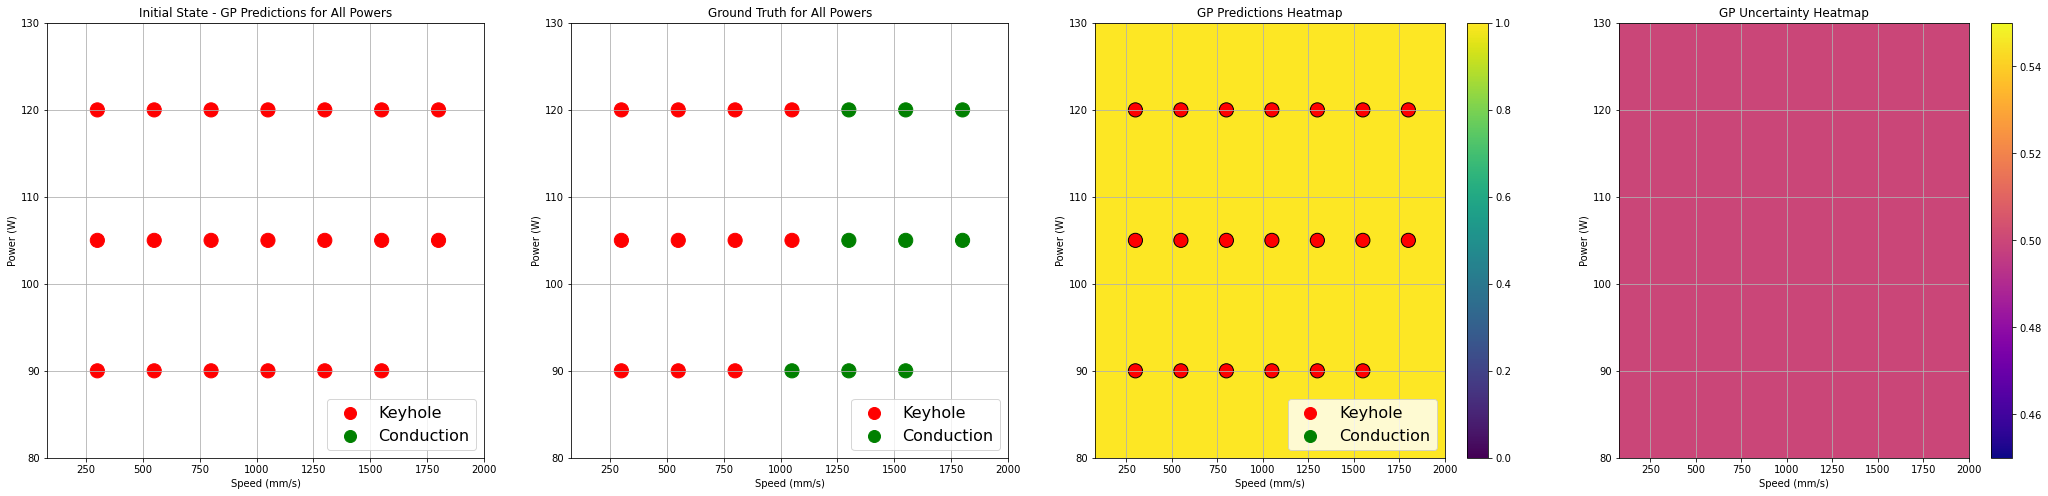

Initial power selected: 90
Performing initial clustering for power: 90
Clustering completed for power: 90
Gaussian Process model training completed.
Initial Precision: 0.9166666666666666
Initial Recall: 1.0
Initial F1-score: 0.9565217391304348
Number of experiments done so far: 6


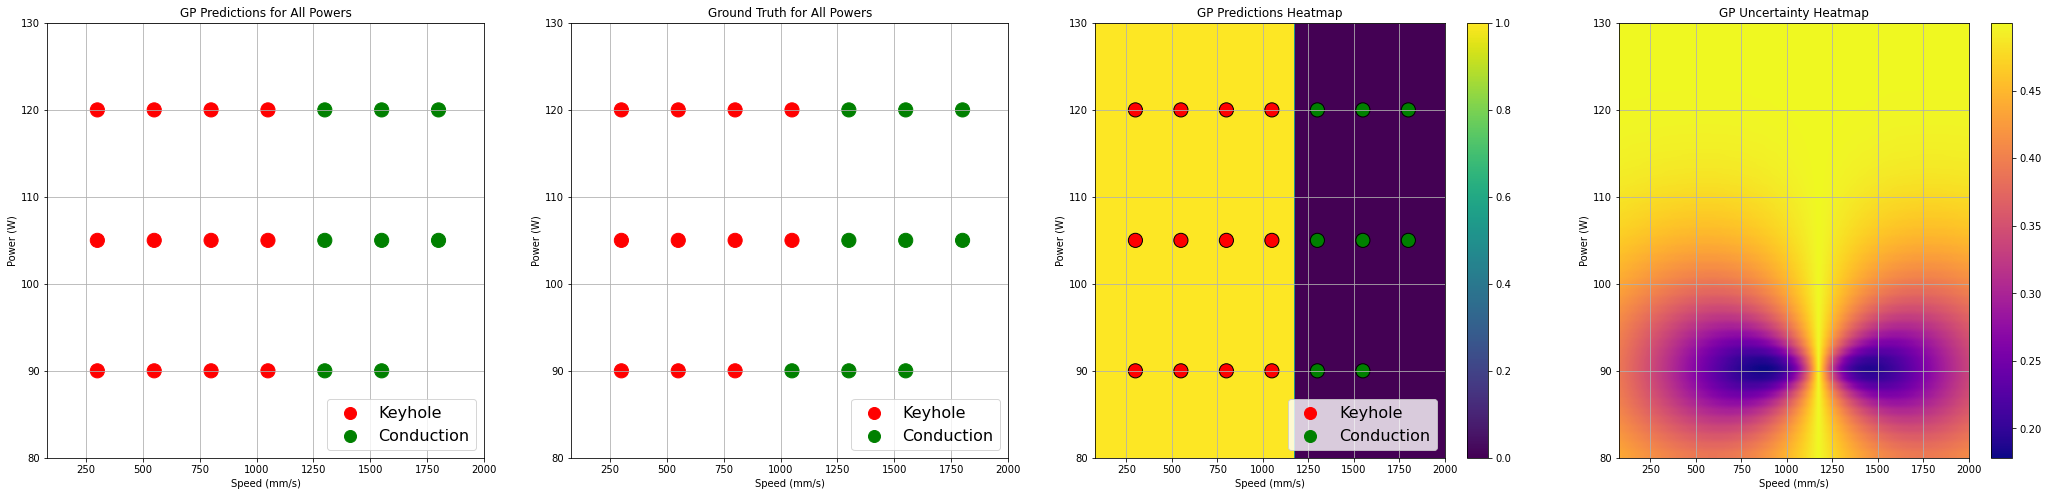

Next power selected based on uncertainty: 120
Performing initial clustering for power: 120
Clustering completed for power: 120
Gaussian Process model training completed.
Iteration 1 - Precision: 0.9166666666666666, Recall: 1.0, F1-score: 0.9565217391304348
Number of experiments done so far: 13


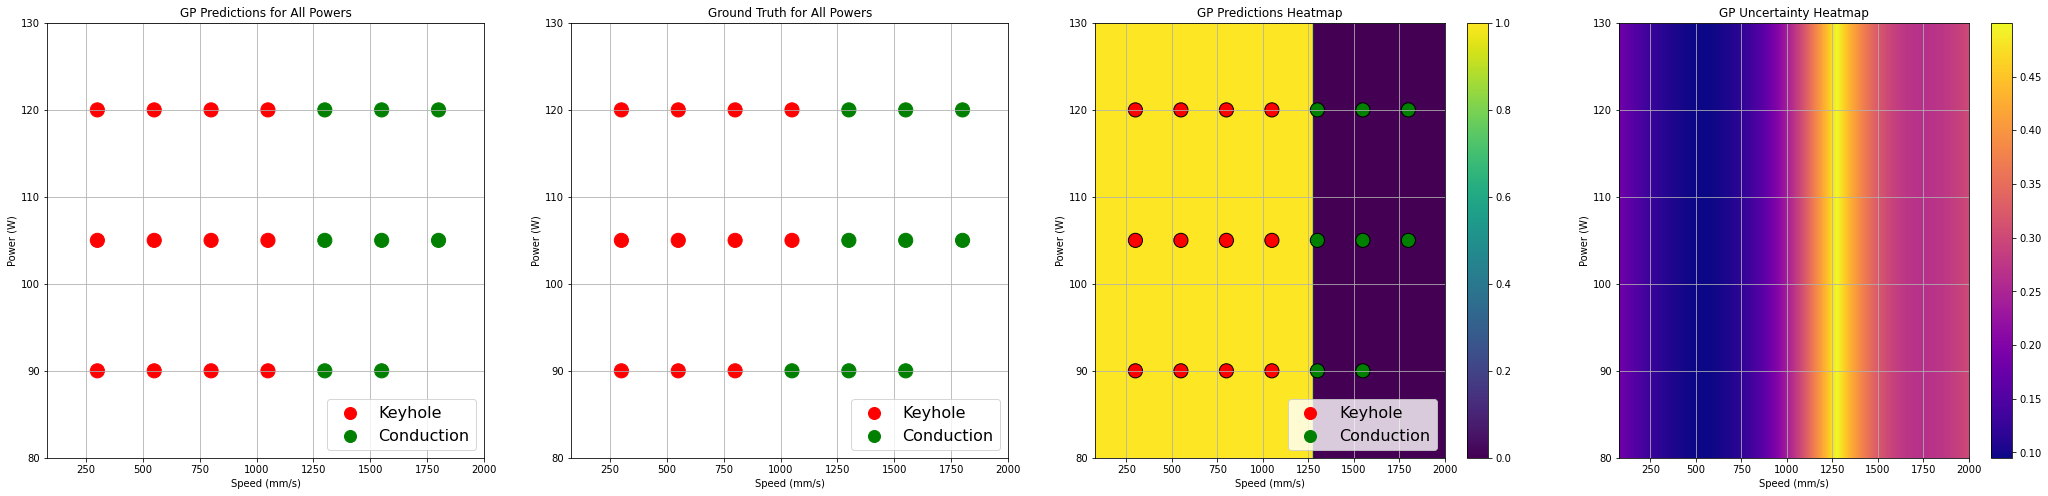

Next power selected based on uncertainty: 105
Performing initial clustering for power: 105
Clustering completed for power: 105
Gaussian Process model training completed.
Iteration 2 - Precision: 0.9166666666666666, Recall: 1.0, F1-score: 0.9565217391304348
Number of experiments done so far: 20


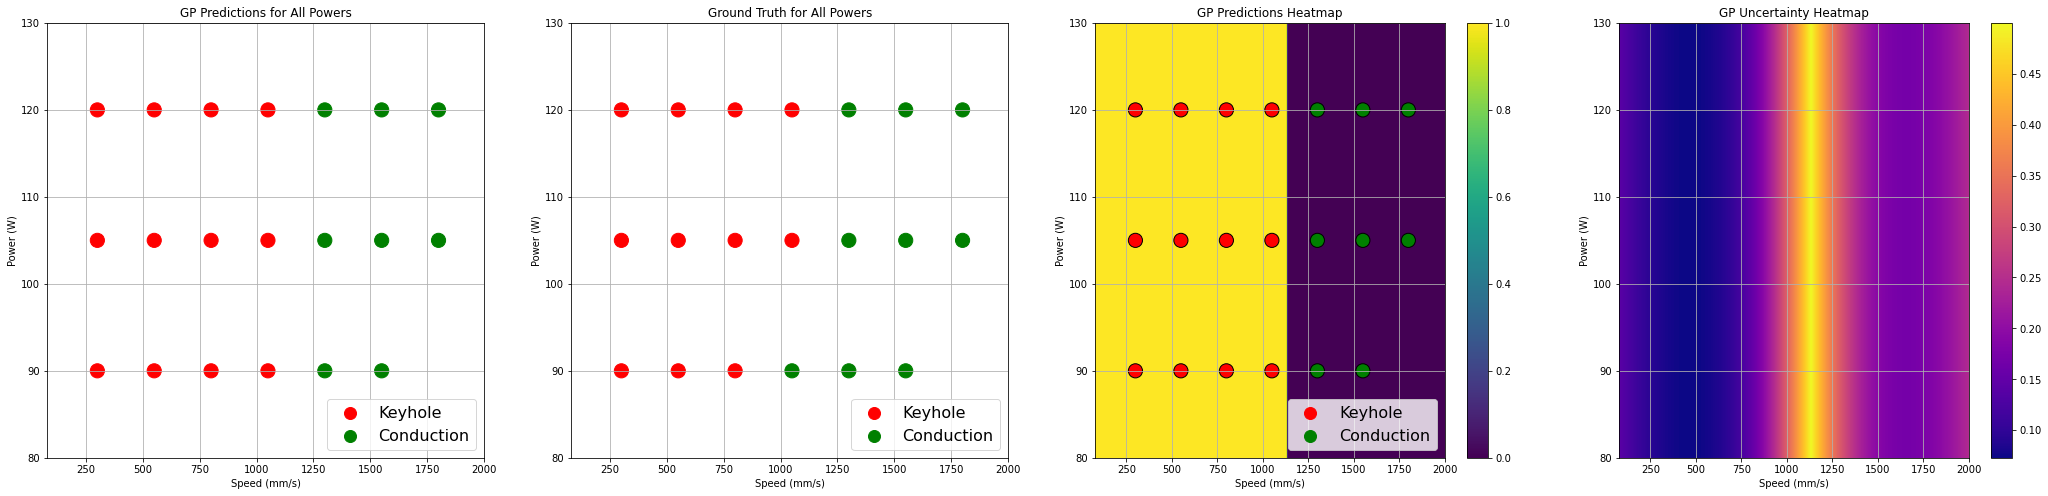

Ti64


Number of Experiments  F1-score  Precision  Recall
0                      6    0.9565     0.9167     1.0
1                     13    0.9565     0.9167     1.0
2                     20    0.9565     0.9167     1.0

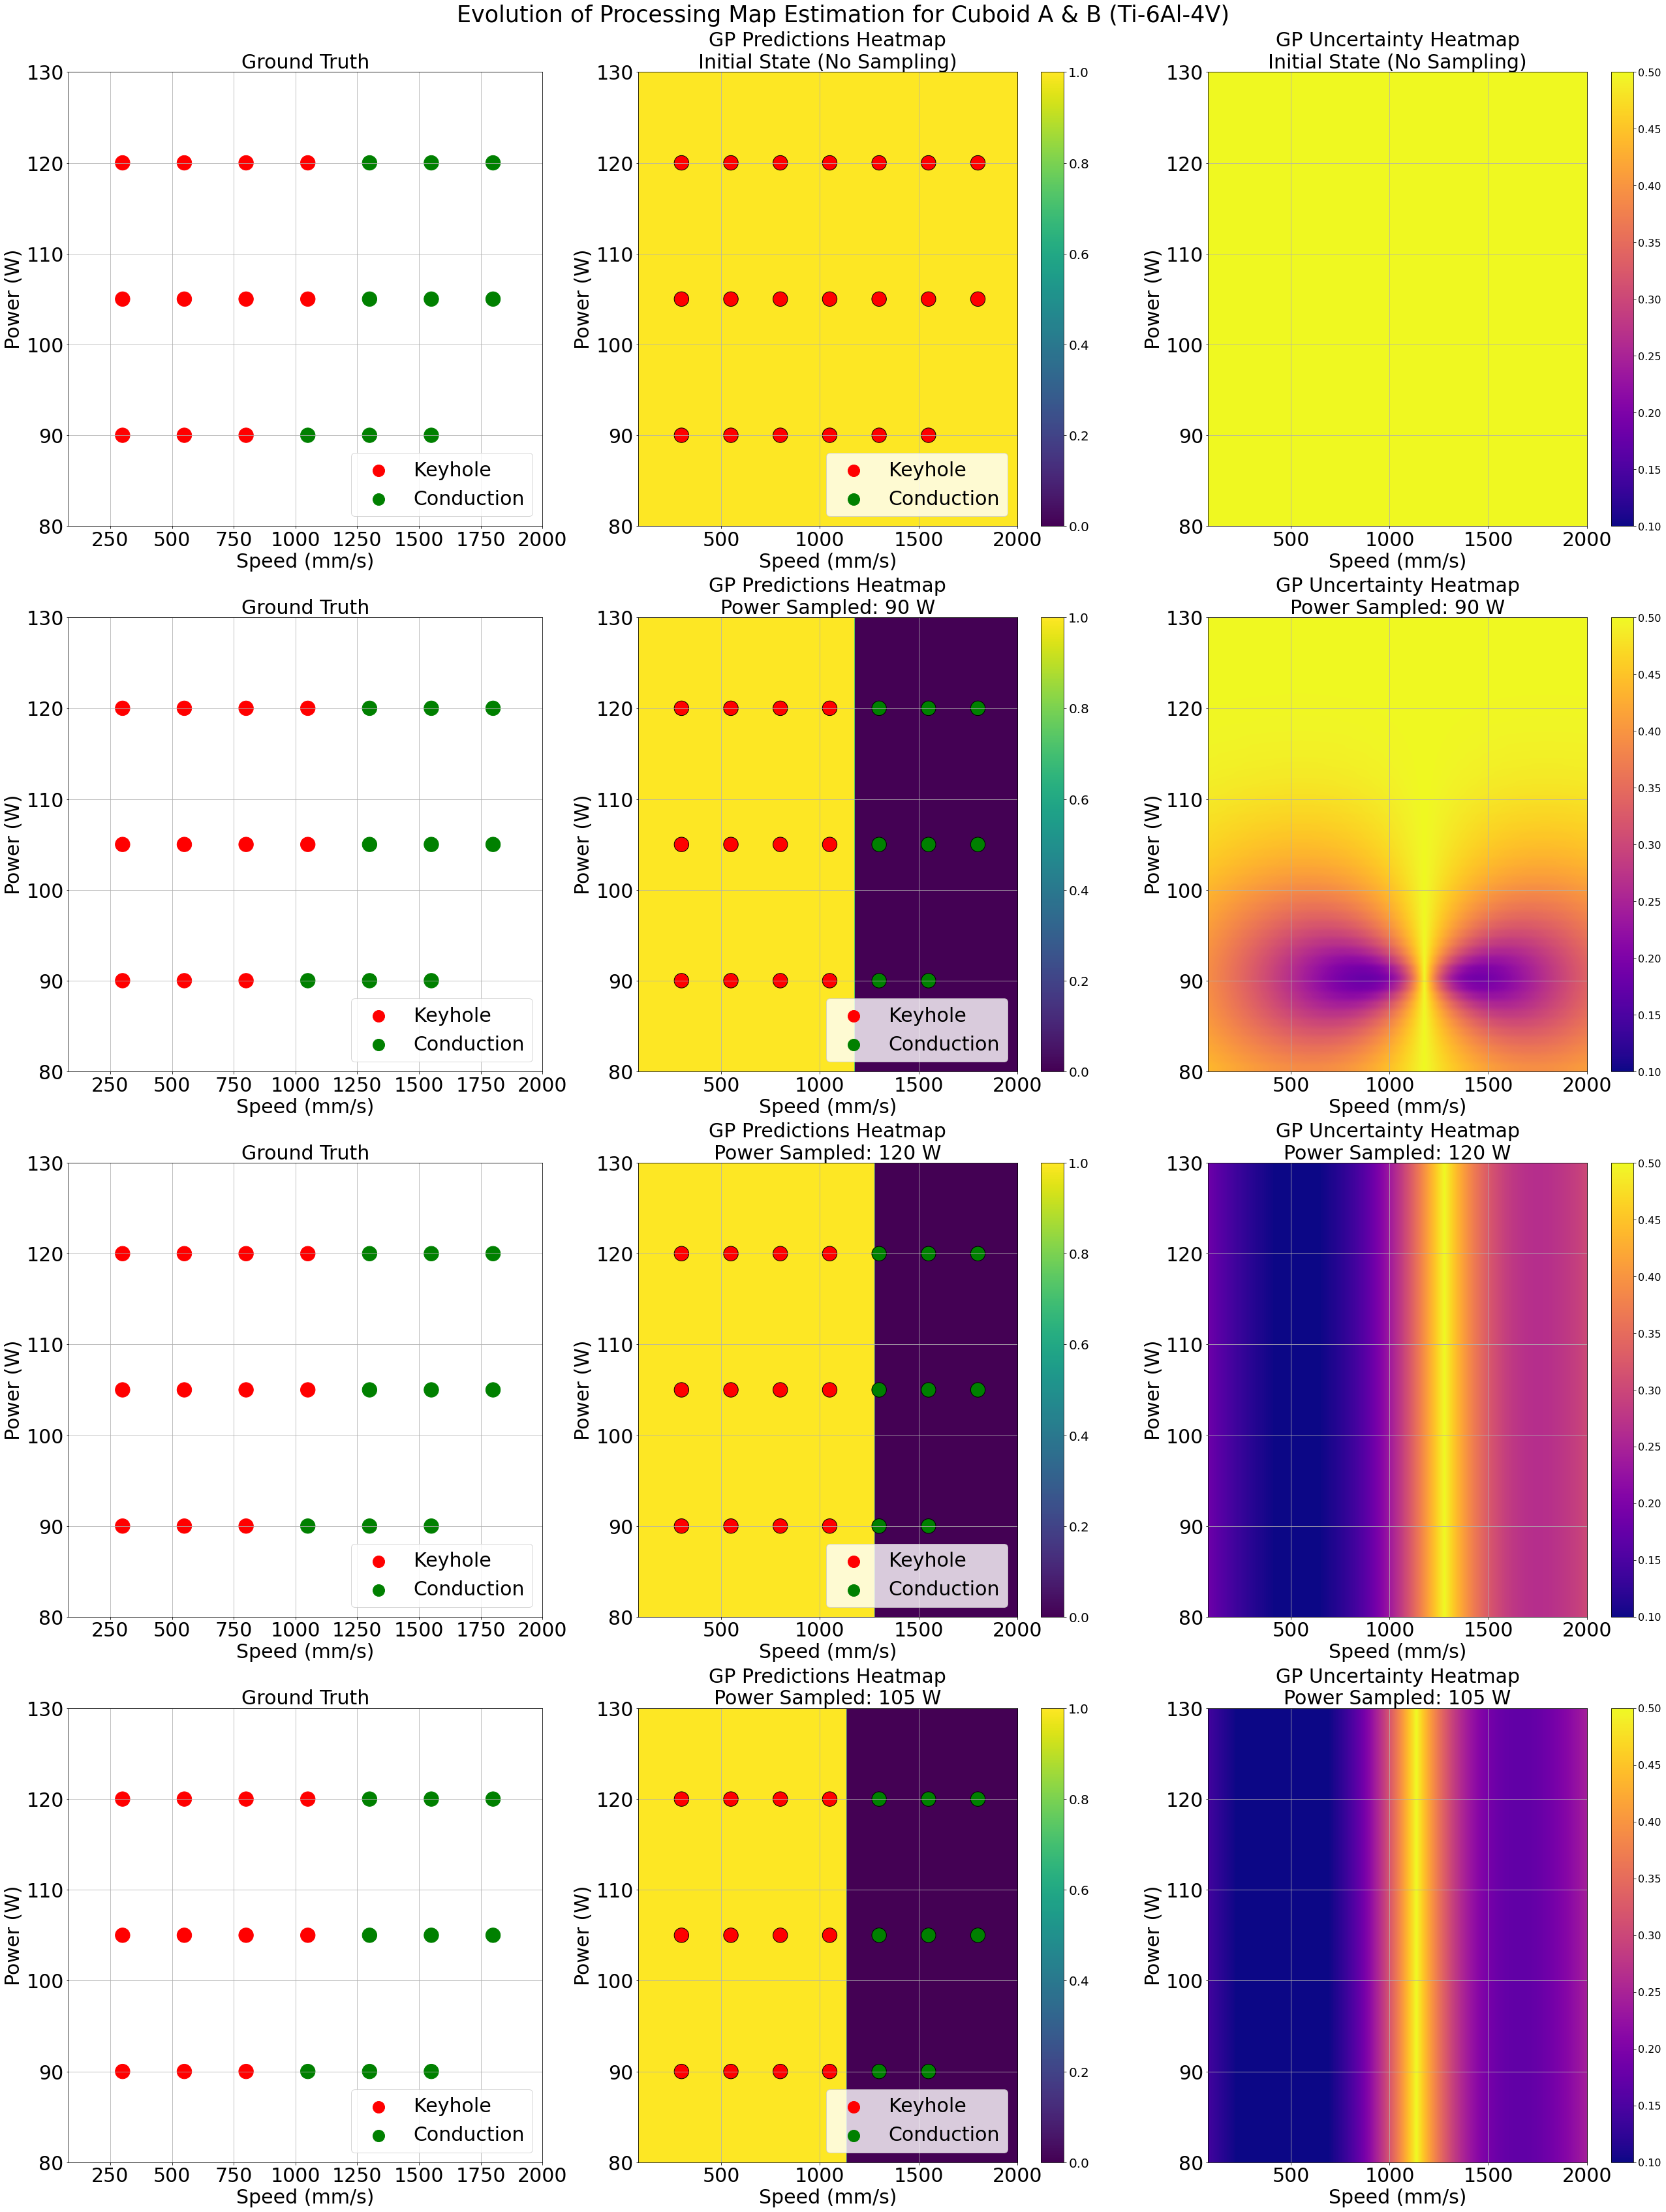

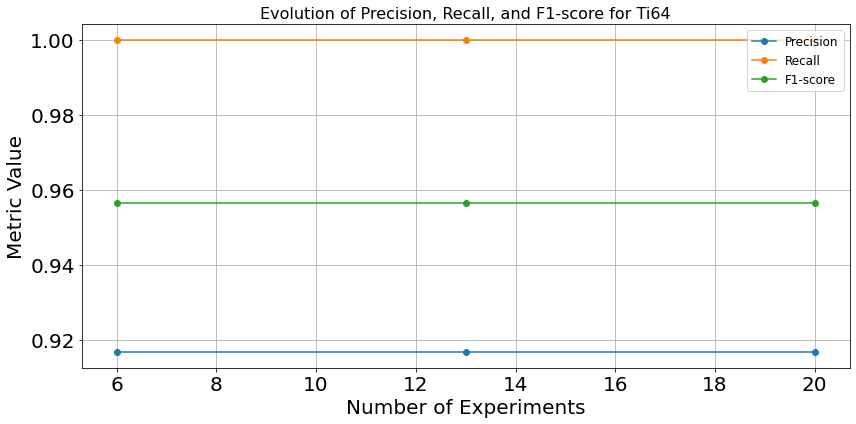

In [3]:
material = 'Ti64'
cube_numbers = [1, 2]
cube_names = 'A & B'

res = active_learning(material, cube_numbers, cube_names)
res

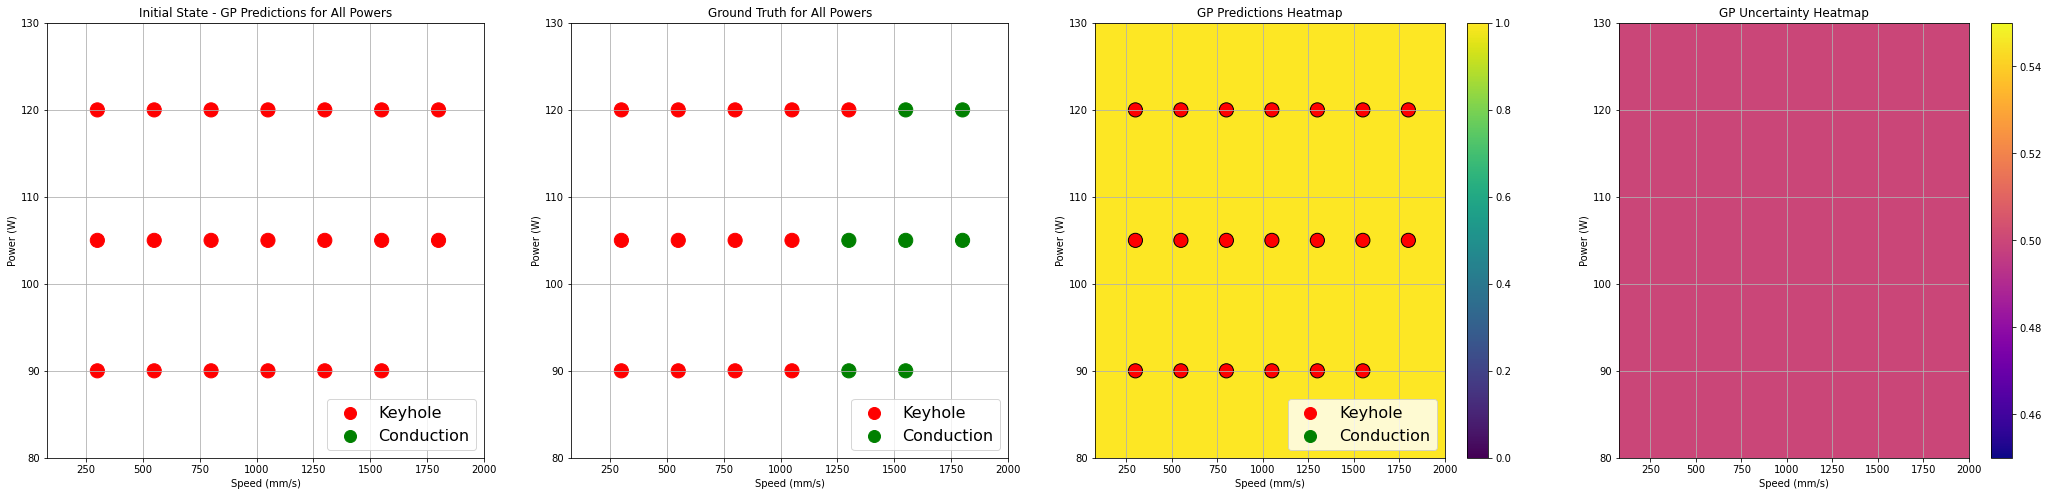

Initial power selected: 105
Performing initial clustering for power: 105
Clustering completed for power: 105
Gaussian Process model training completed.
Initial Precision: 1.0
Initial Recall: 0.6923076923076923
Initial F1-score: 0.8181818181818181
Number of experiments done so far: 7


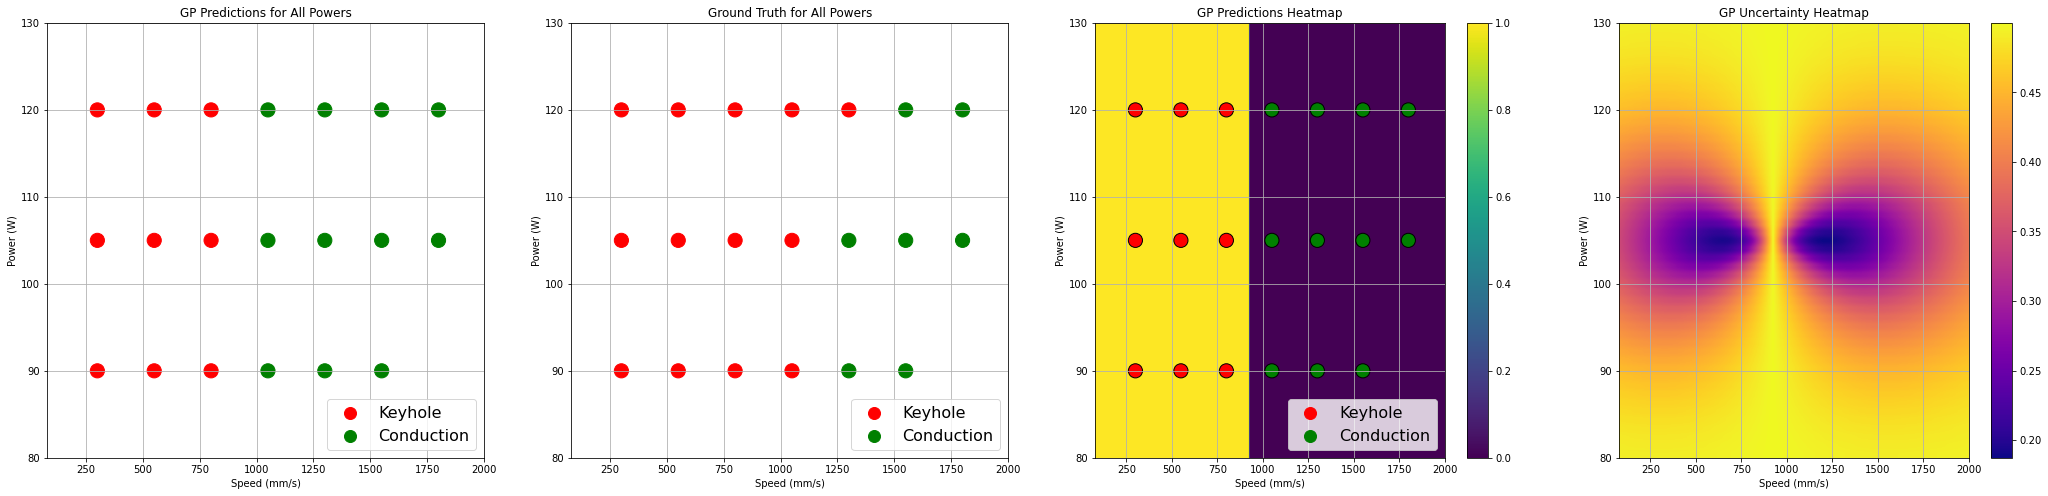

Next power selected based on uncertainty: 90
Performing initial clustering for power: 90
Clustering completed for power: 90
Gaussian Process model training completed.
Iteration 1 - Precision: 1.0, Recall: 0.6923076923076923, F1-score: 0.8181818181818181
Number of experiments done so far: 13


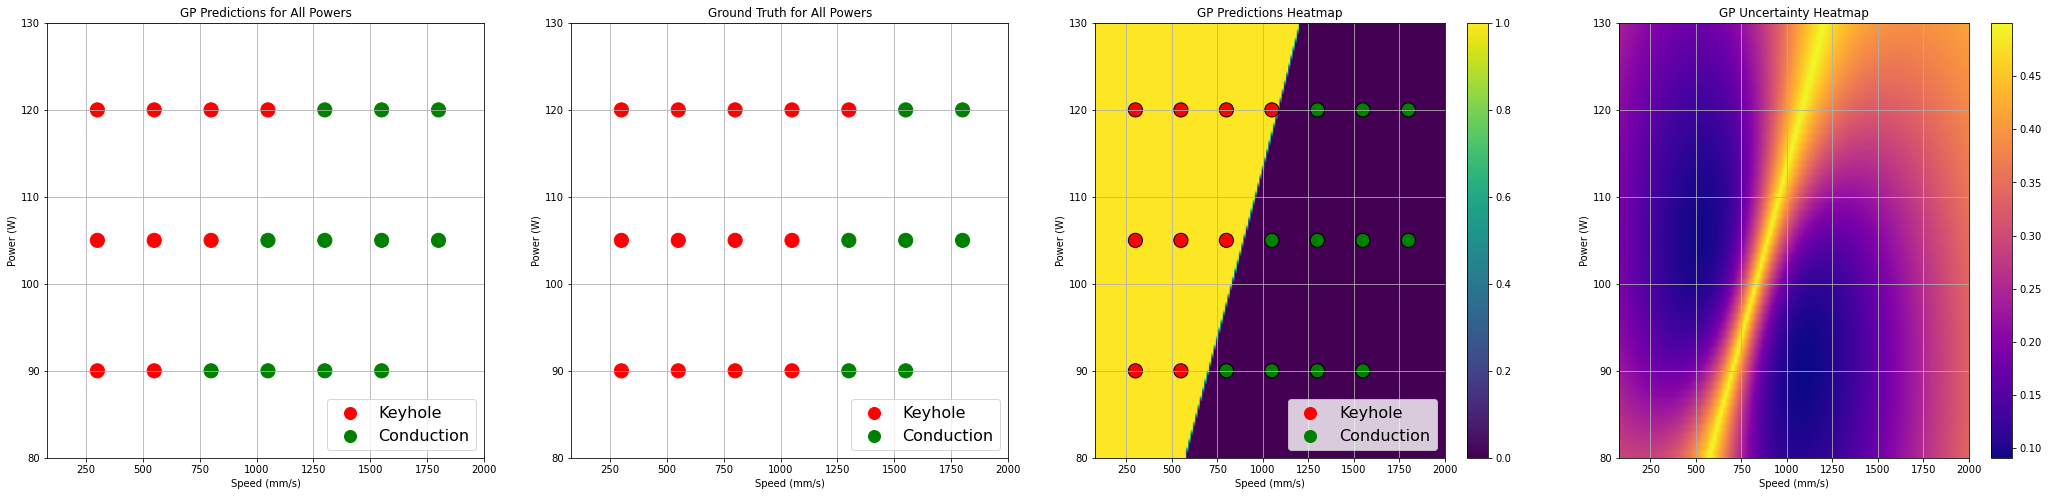

Next power selected based on uncertainty: 120
Performing initial clustering for power: 120
Clustering completed for power: 120
Gaussian Process model training completed.
Iteration 2 - Precision: 1.0, Recall: 0.6923076923076923, F1-score: 0.8181818181818181
Number of experiments done so far: 20


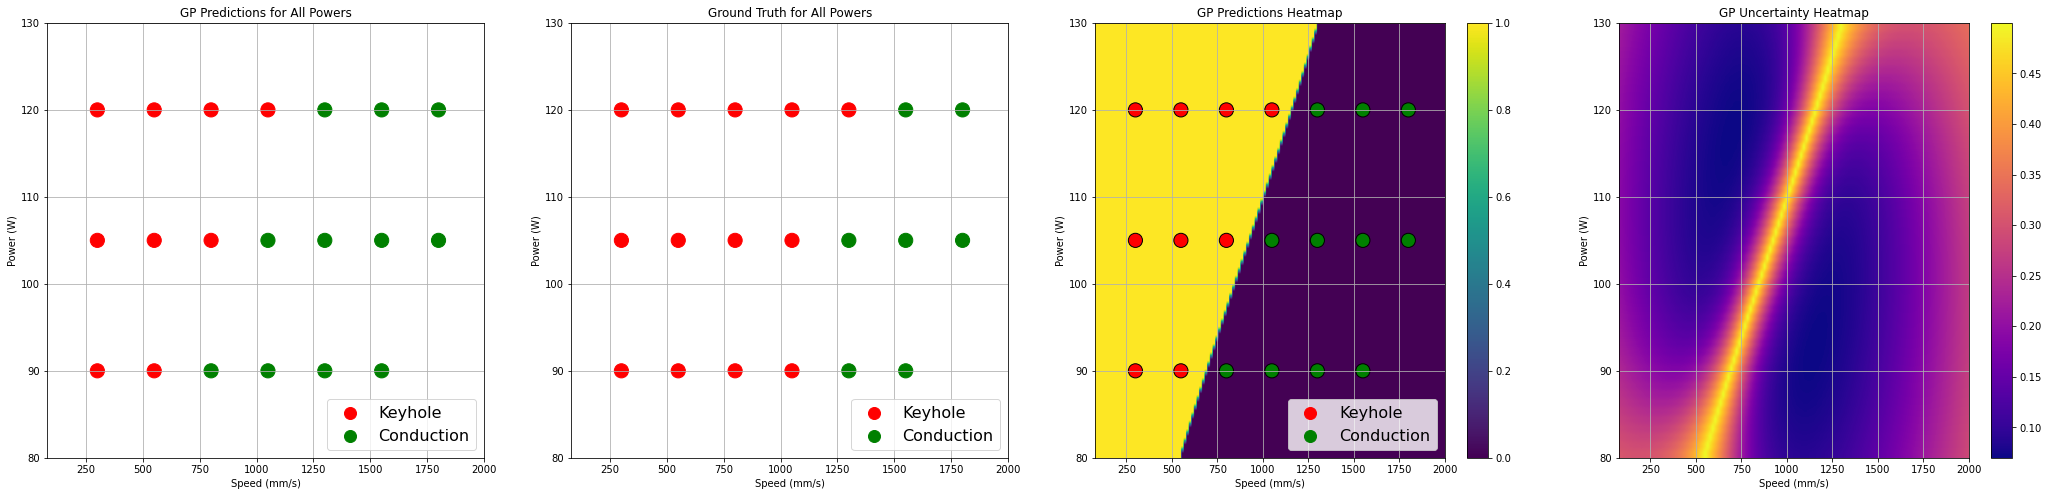

Ti64


Number of Experiments  F1-score  Precision  Recall
0                      7    0.8182        1.0  0.6923
1                     13    0.8182        1.0  0.6923
2                     20    0.8182        1.0  0.6923

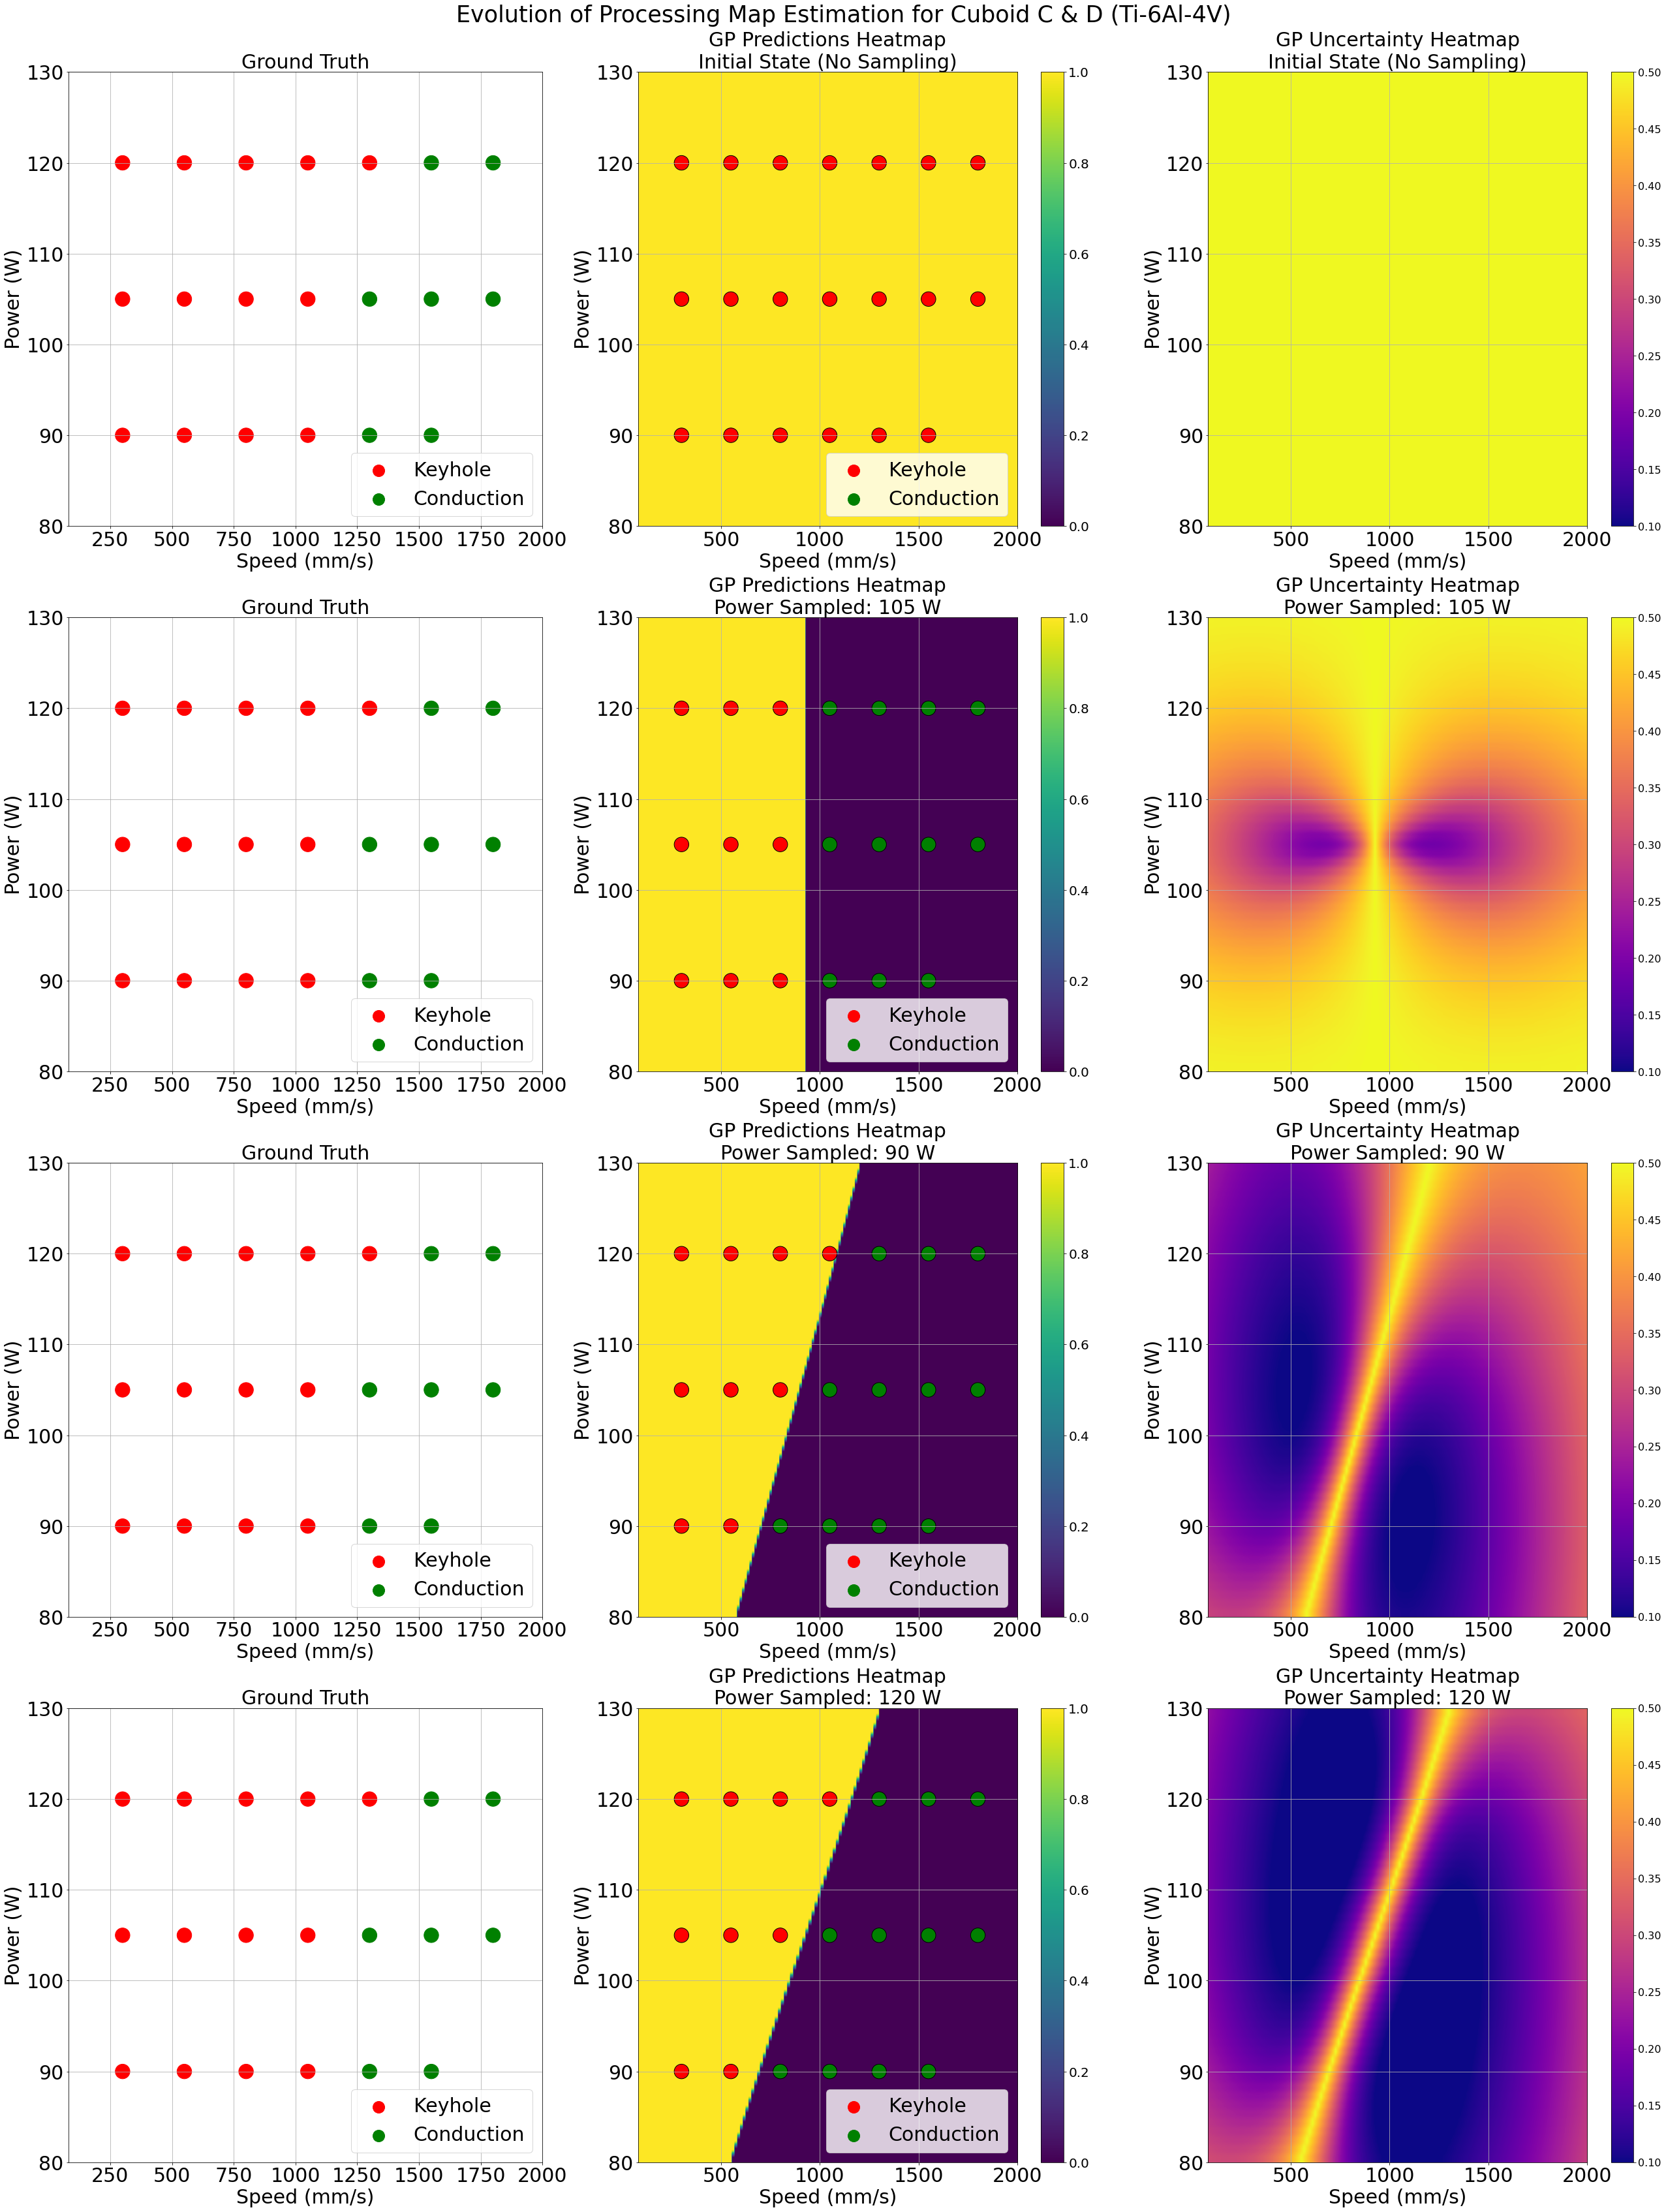

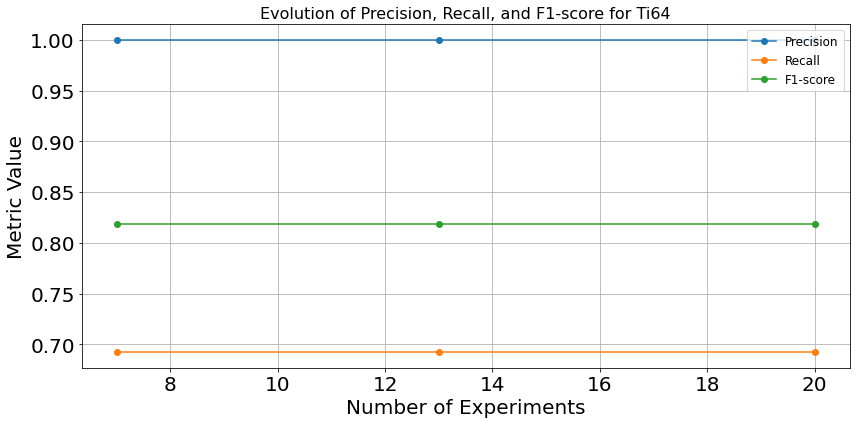

In [4]:
material = 'Ti64'
cube_numbers = [3, 4]
cube_names = 'C & D'

active_learning(material, cube_numbers, cube_names)

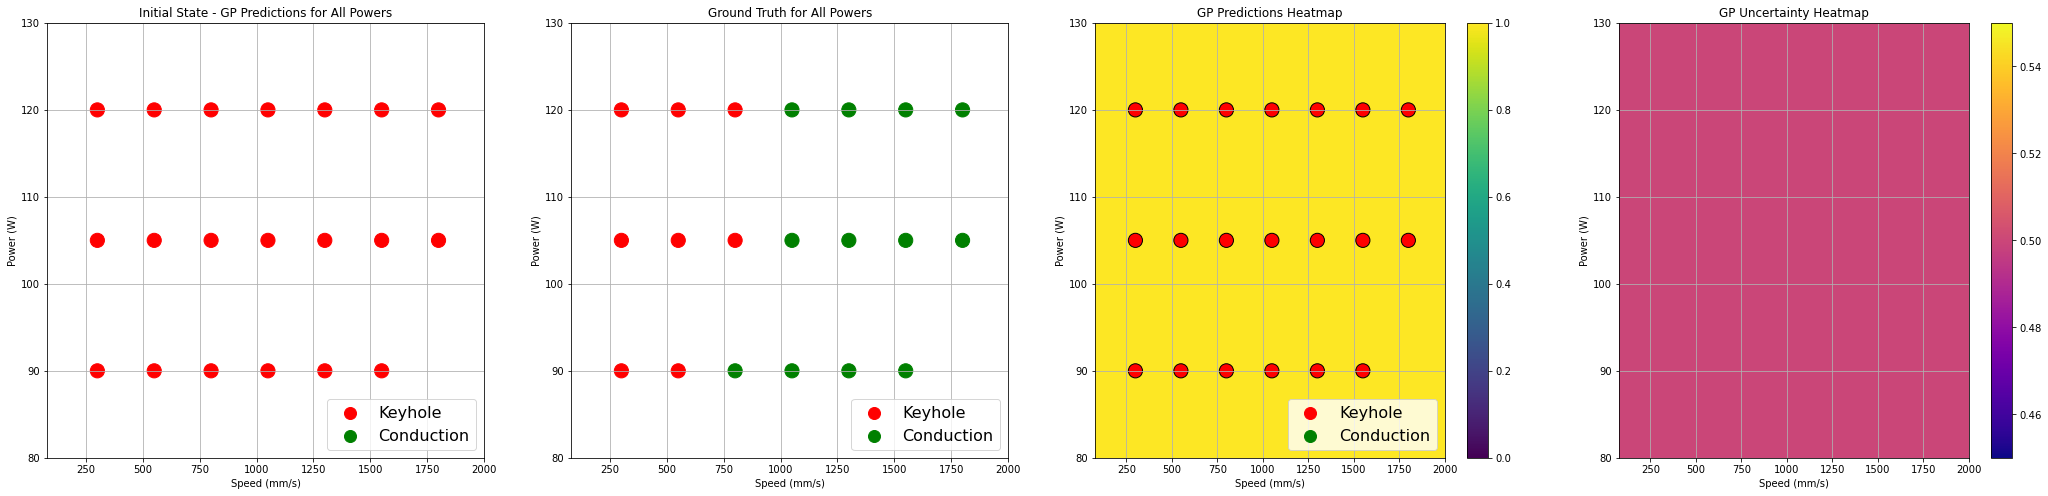

Initial power selected: 120
Performing initial clustering for power: 120
Clustering completed for power: 120
Gaussian Process model training completed.
Initial Precision: 0.8888888888888888
Initial Recall: 1.0
Initial F1-score: 0.9411764705882353
Number of experiments done so far: 7


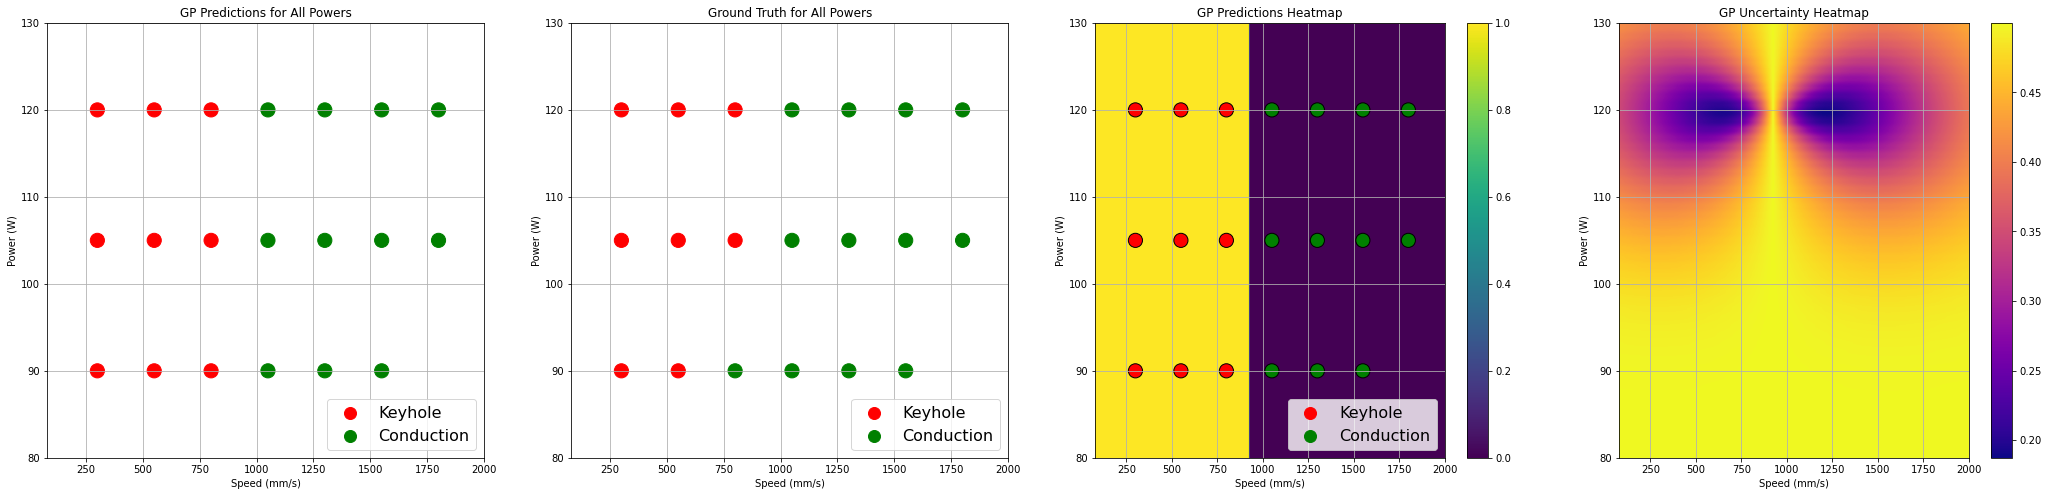

Next power selected based on uncertainty: 90
Performing initial clustering for power: 90
Clustering completed for power: 90
Gaussian Process model training completed.
Iteration 1 - Precision: 0.8888888888888888, Recall: 1.0, F1-score: 0.9411764705882353
Number of experiments done so far: 13


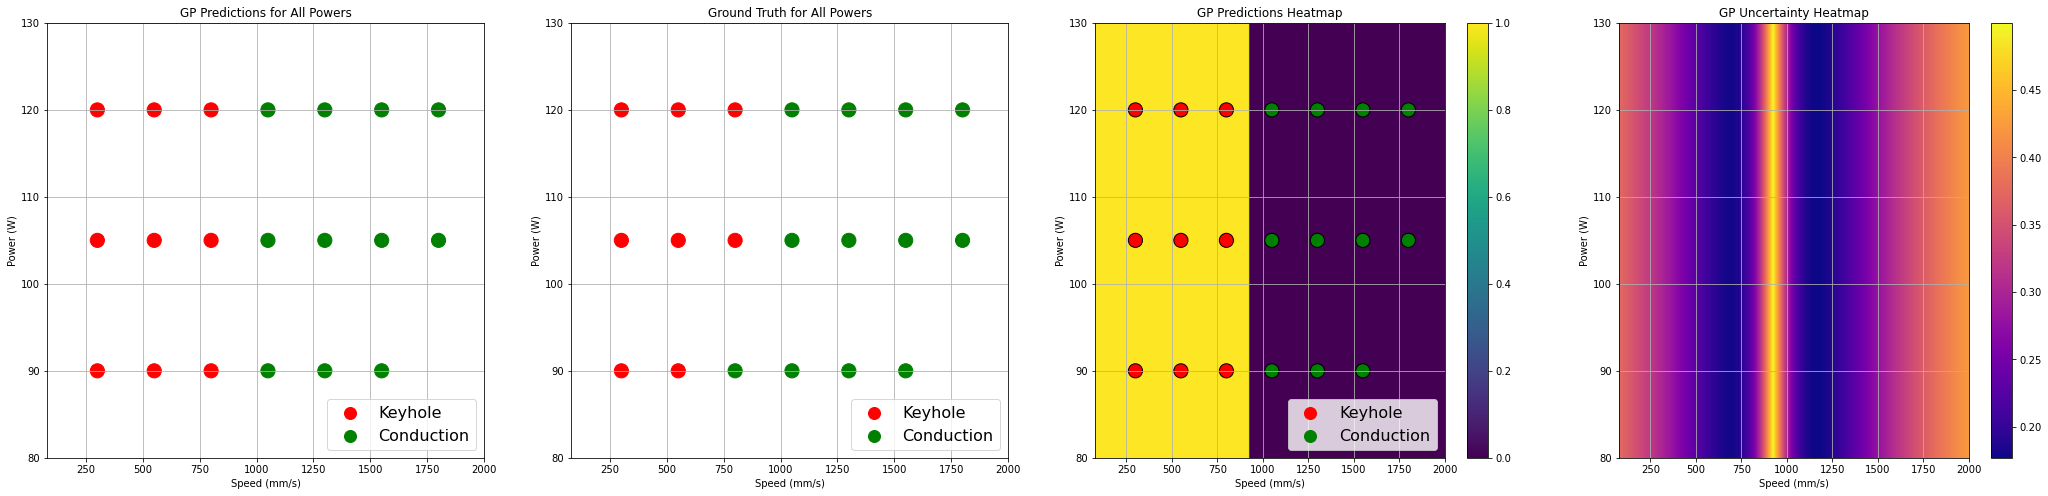

Next power selected based on uncertainty: 105
Performing initial clustering for power: 105
Clustering completed for power: 105
Gaussian Process model training completed.
Iteration 2 - Precision: 0.8888888888888888, Recall: 1.0, F1-score: 0.9411764705882353
Number of experiments done so far: 20


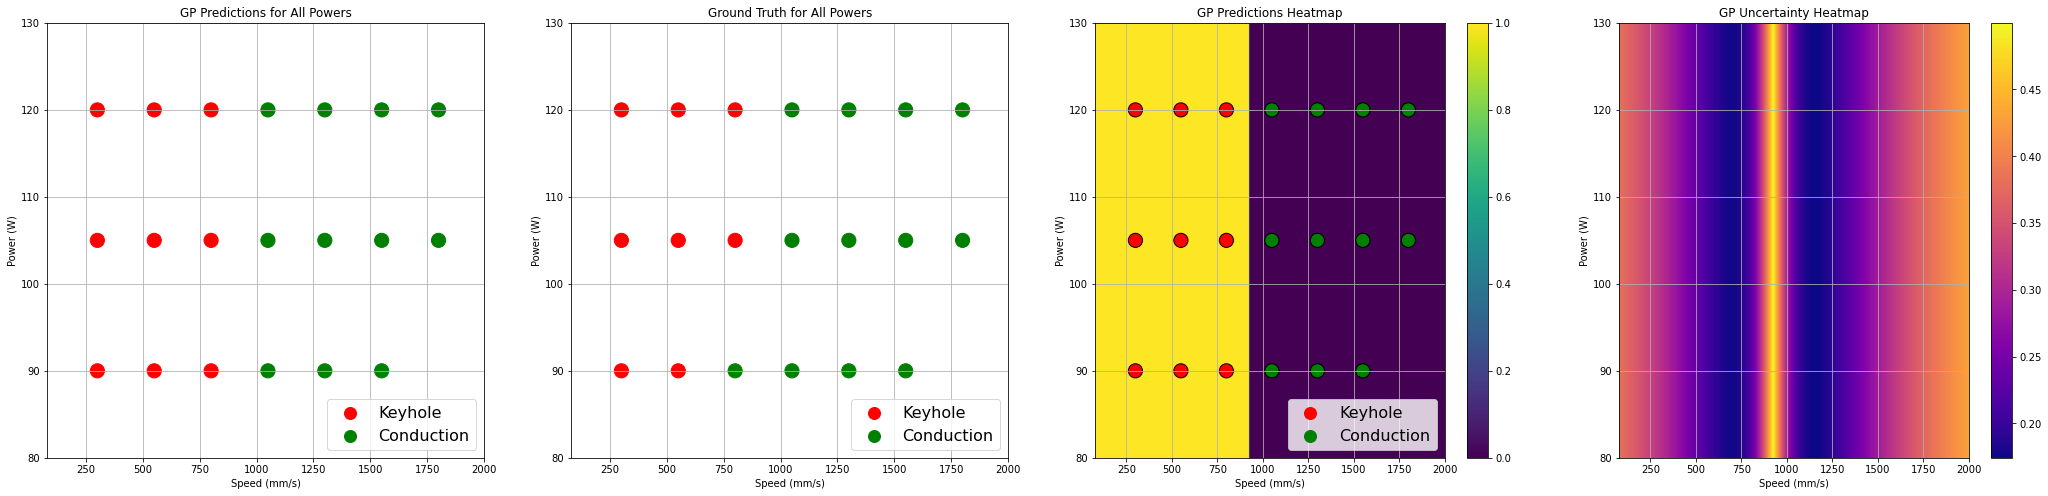

316L


Number of Experiments  F1-score  Precision  Recall
0                      7    0.9412     0.8889     1.0
1                     13    0.9412     0.8889     1.0
2                     20    0.9412     0.8889     1.0

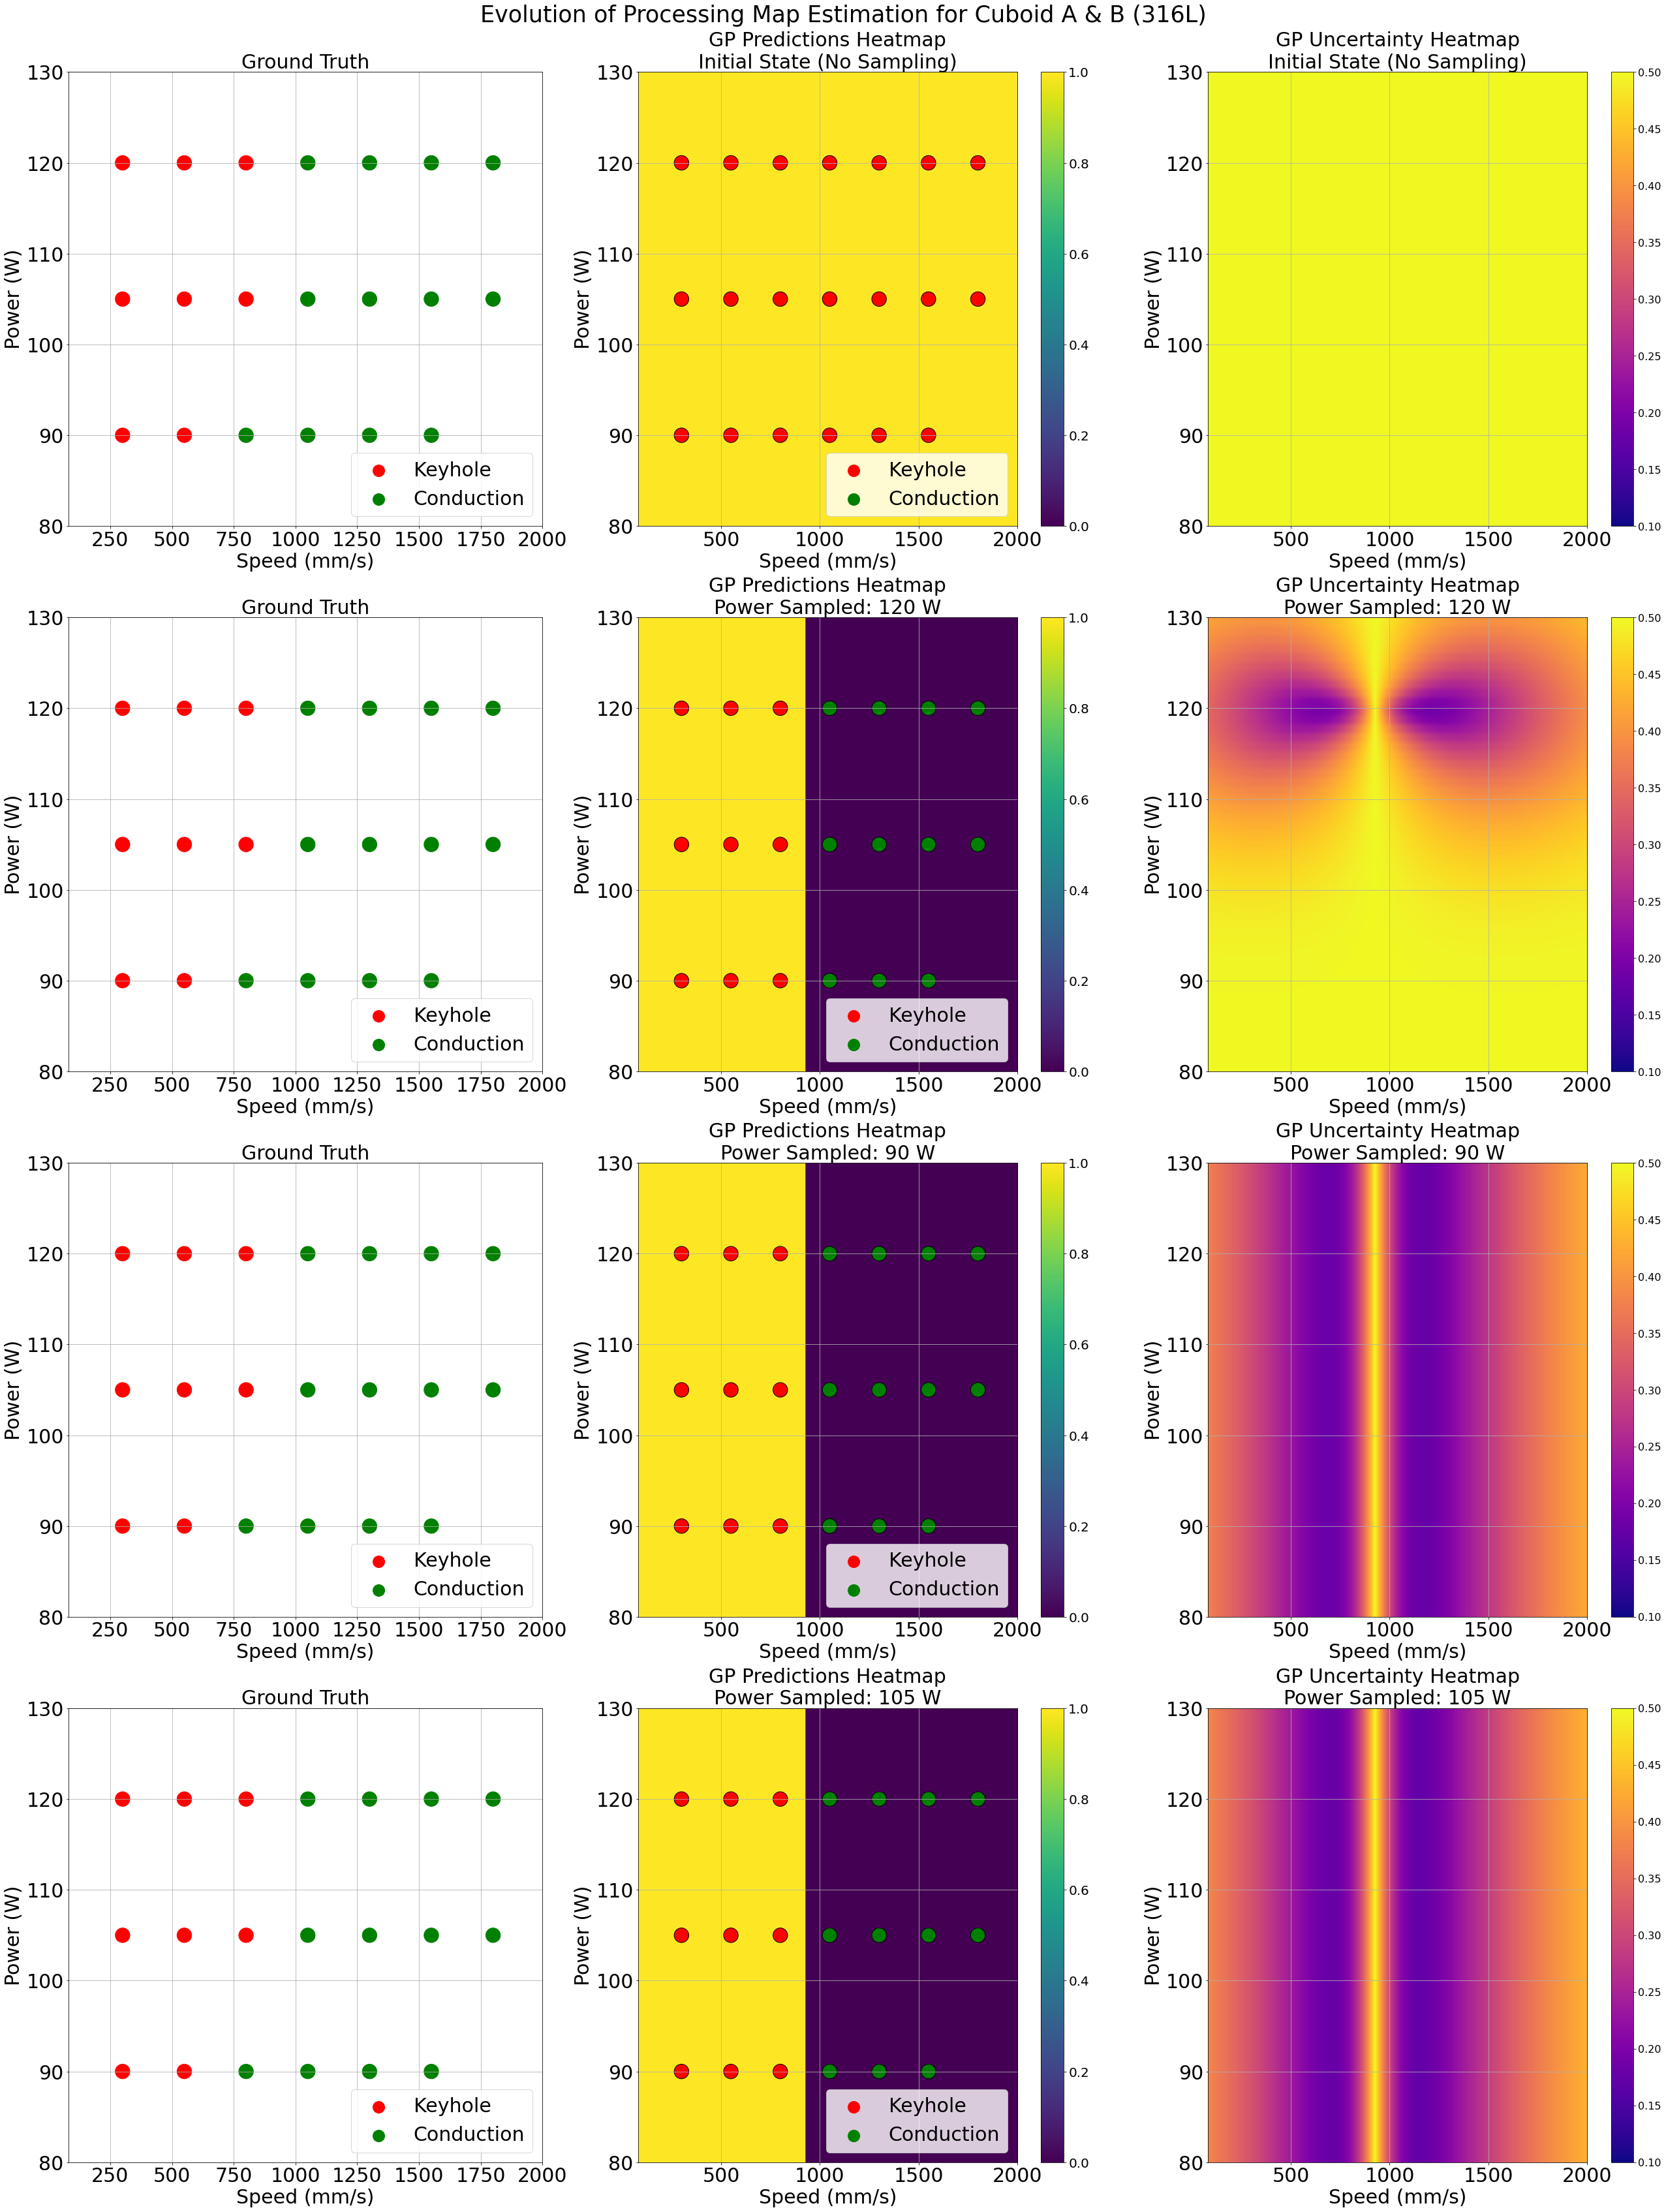

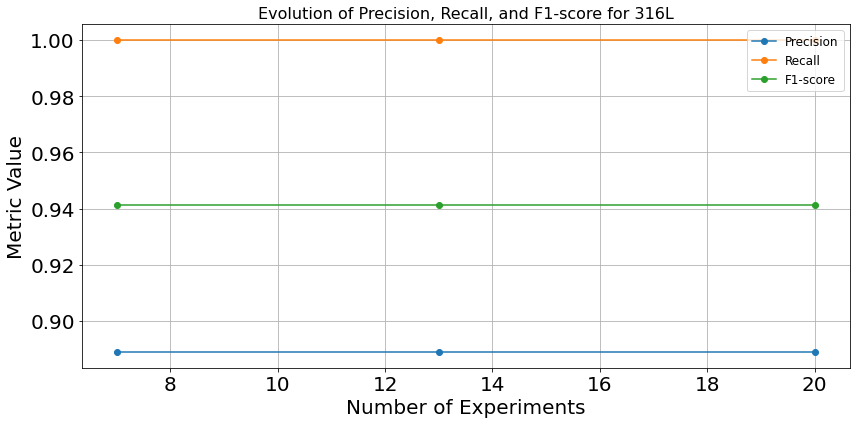

In [6]:
# Load the data
material = '316L'
cube_numbers = [3, 4]
cube_names = 'A & B'

active_learning(material, cube_numbers, cube_names)

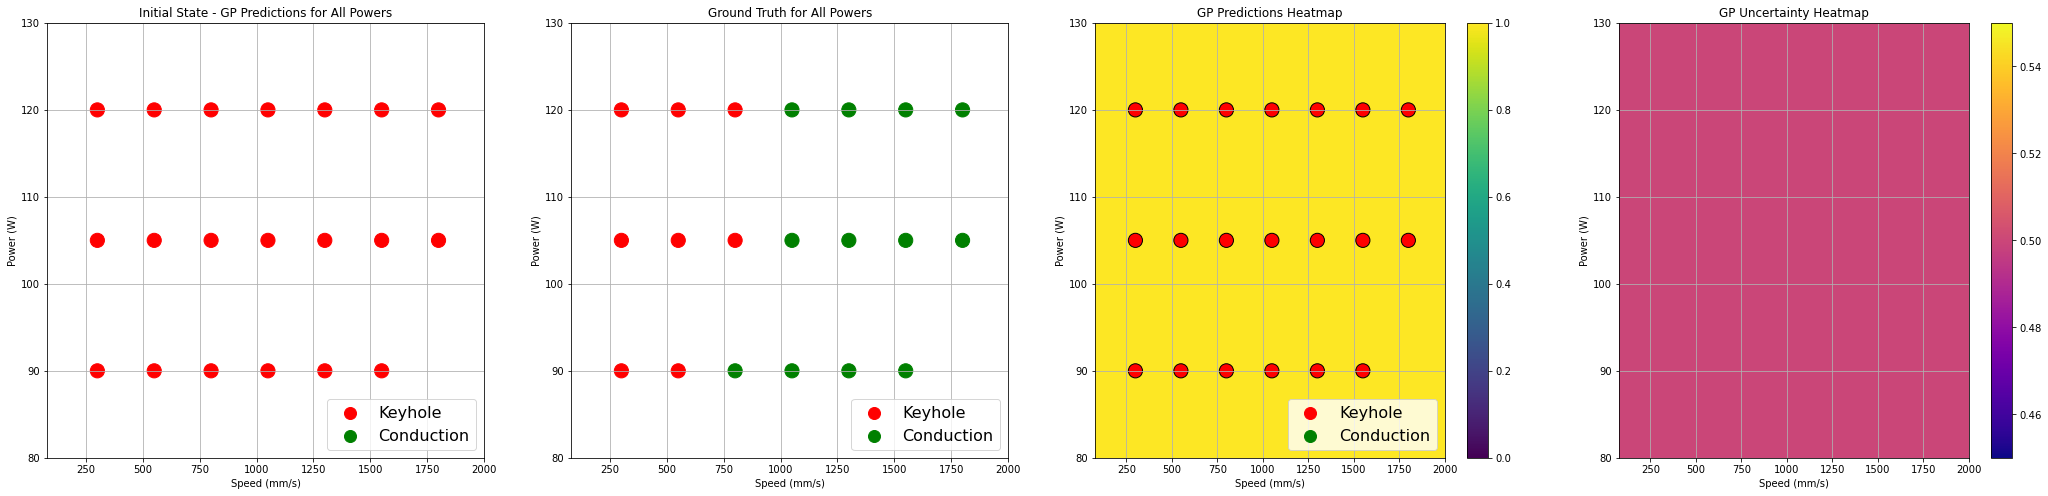

Initial power selected: 90
Performing initial clustering for power: 90
Clustering completed for power: 90
Gaussian Process model training completed.
Initial Precision: 1.0
Initial Recall: 0.75
Initial F1-score: 0.8571428571428571
Number of experiments done so far: 6


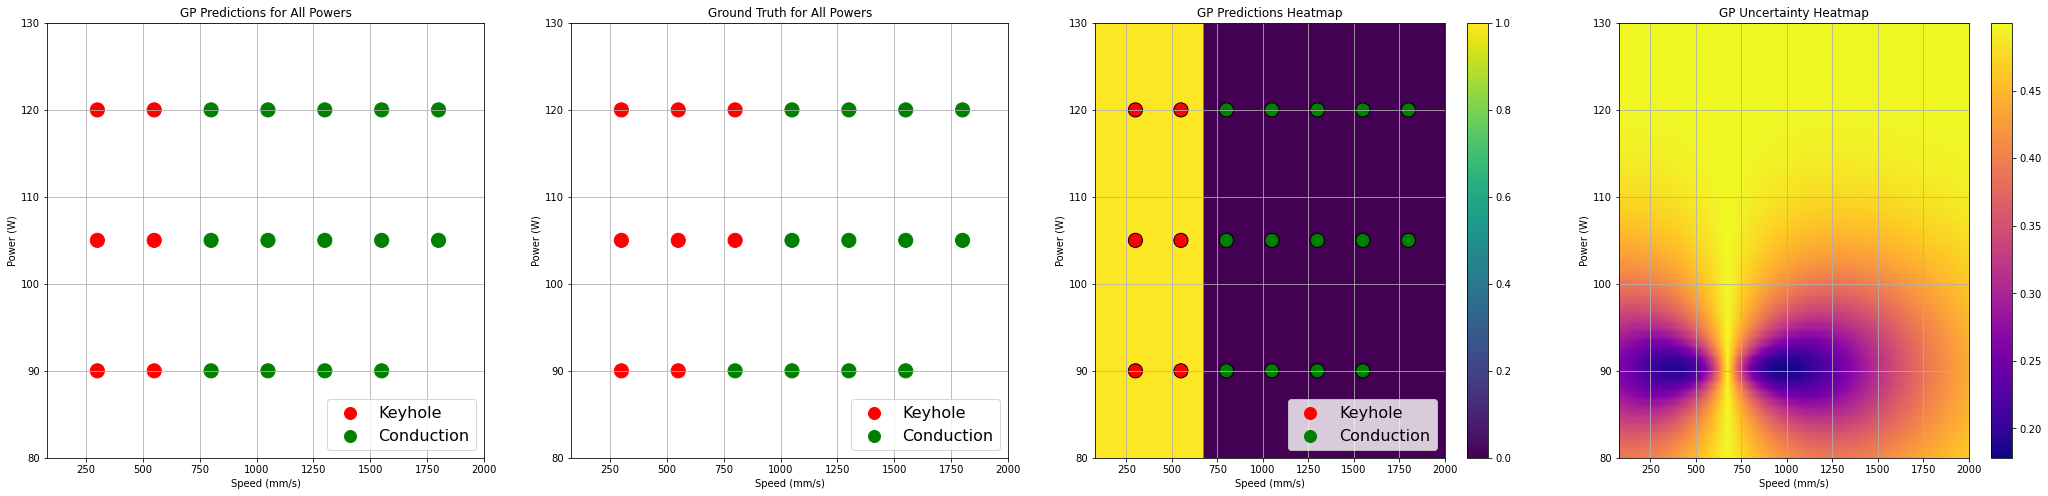

Next power selected based on uncertainty: 120
Performing initial clustering for power: 120
Clustering completed for power: 120
Gaussian Process model training completed.
Iteration 1 - Precision: 0.8888888888888888, Recall: 1.0, F1-score: 0.9411764705882353
Number of experiments done so far: 13


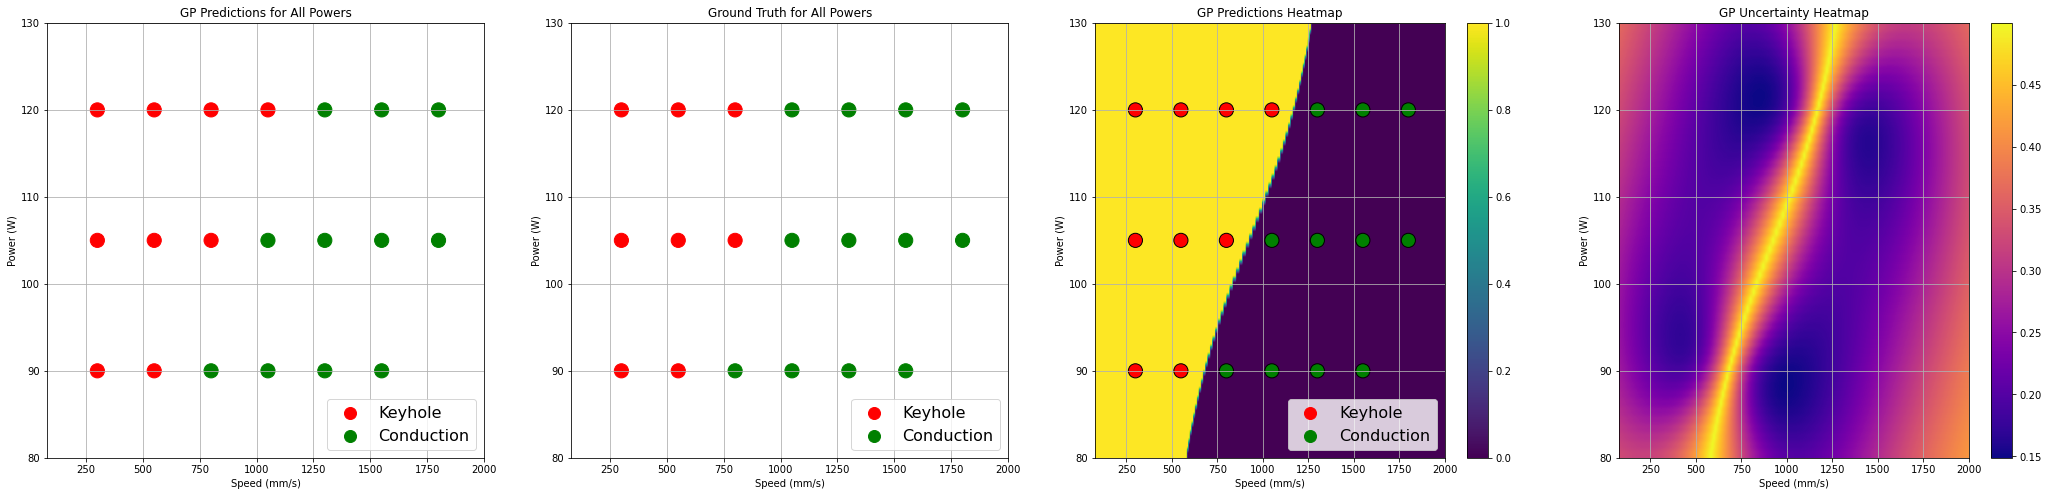

Next power selected based on uncertainty: 105
Performing initial clustering for power: 105
Clustering completed for power: 105
Gaussian Process model training completed.
Iteration 2 - Precision: 0.875, Recall: 0.875, F1-score: 0.875
Number of experiments done so far: 20


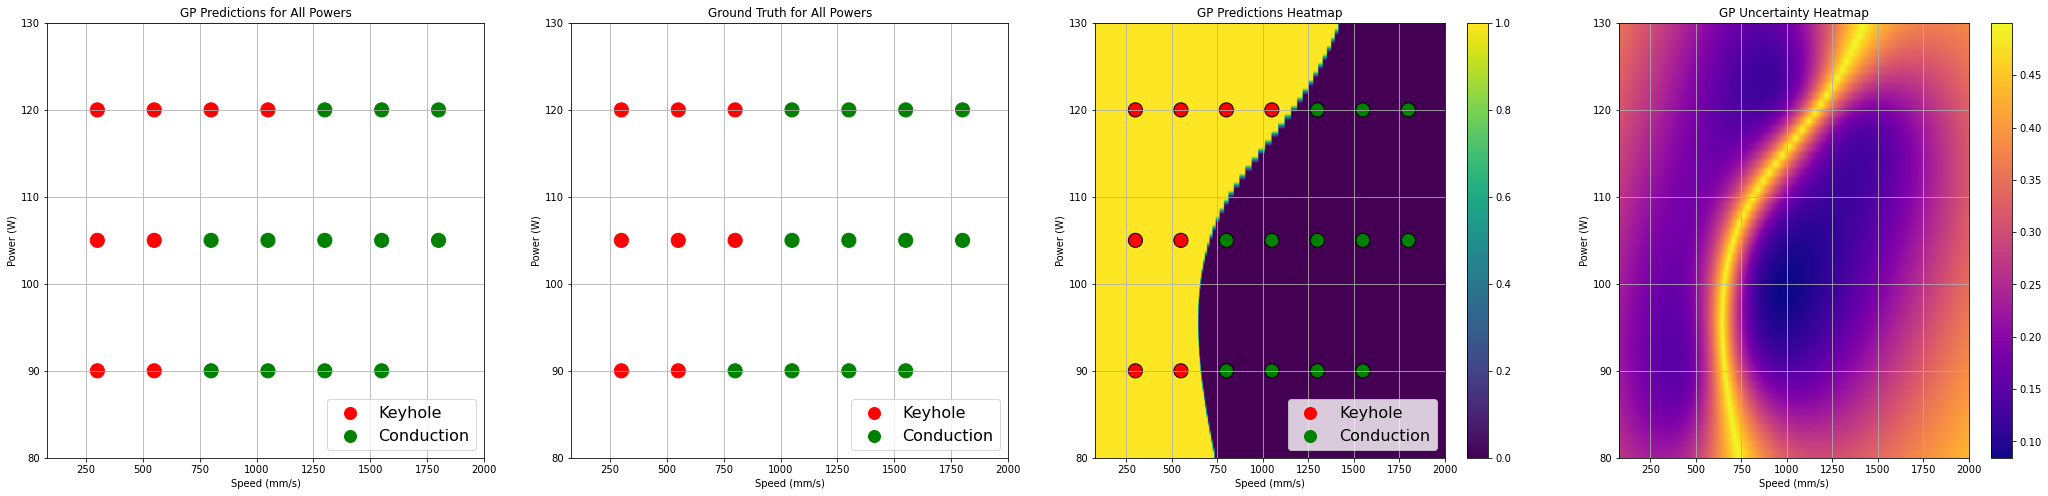

316L


Number of Experiments  F1-score  Precision  Recall
0                      6    0.8571     1.0000   0.750
1                     13    0.9412     0.8889   1.000
2                     20    0.8750     0.8750   0.875

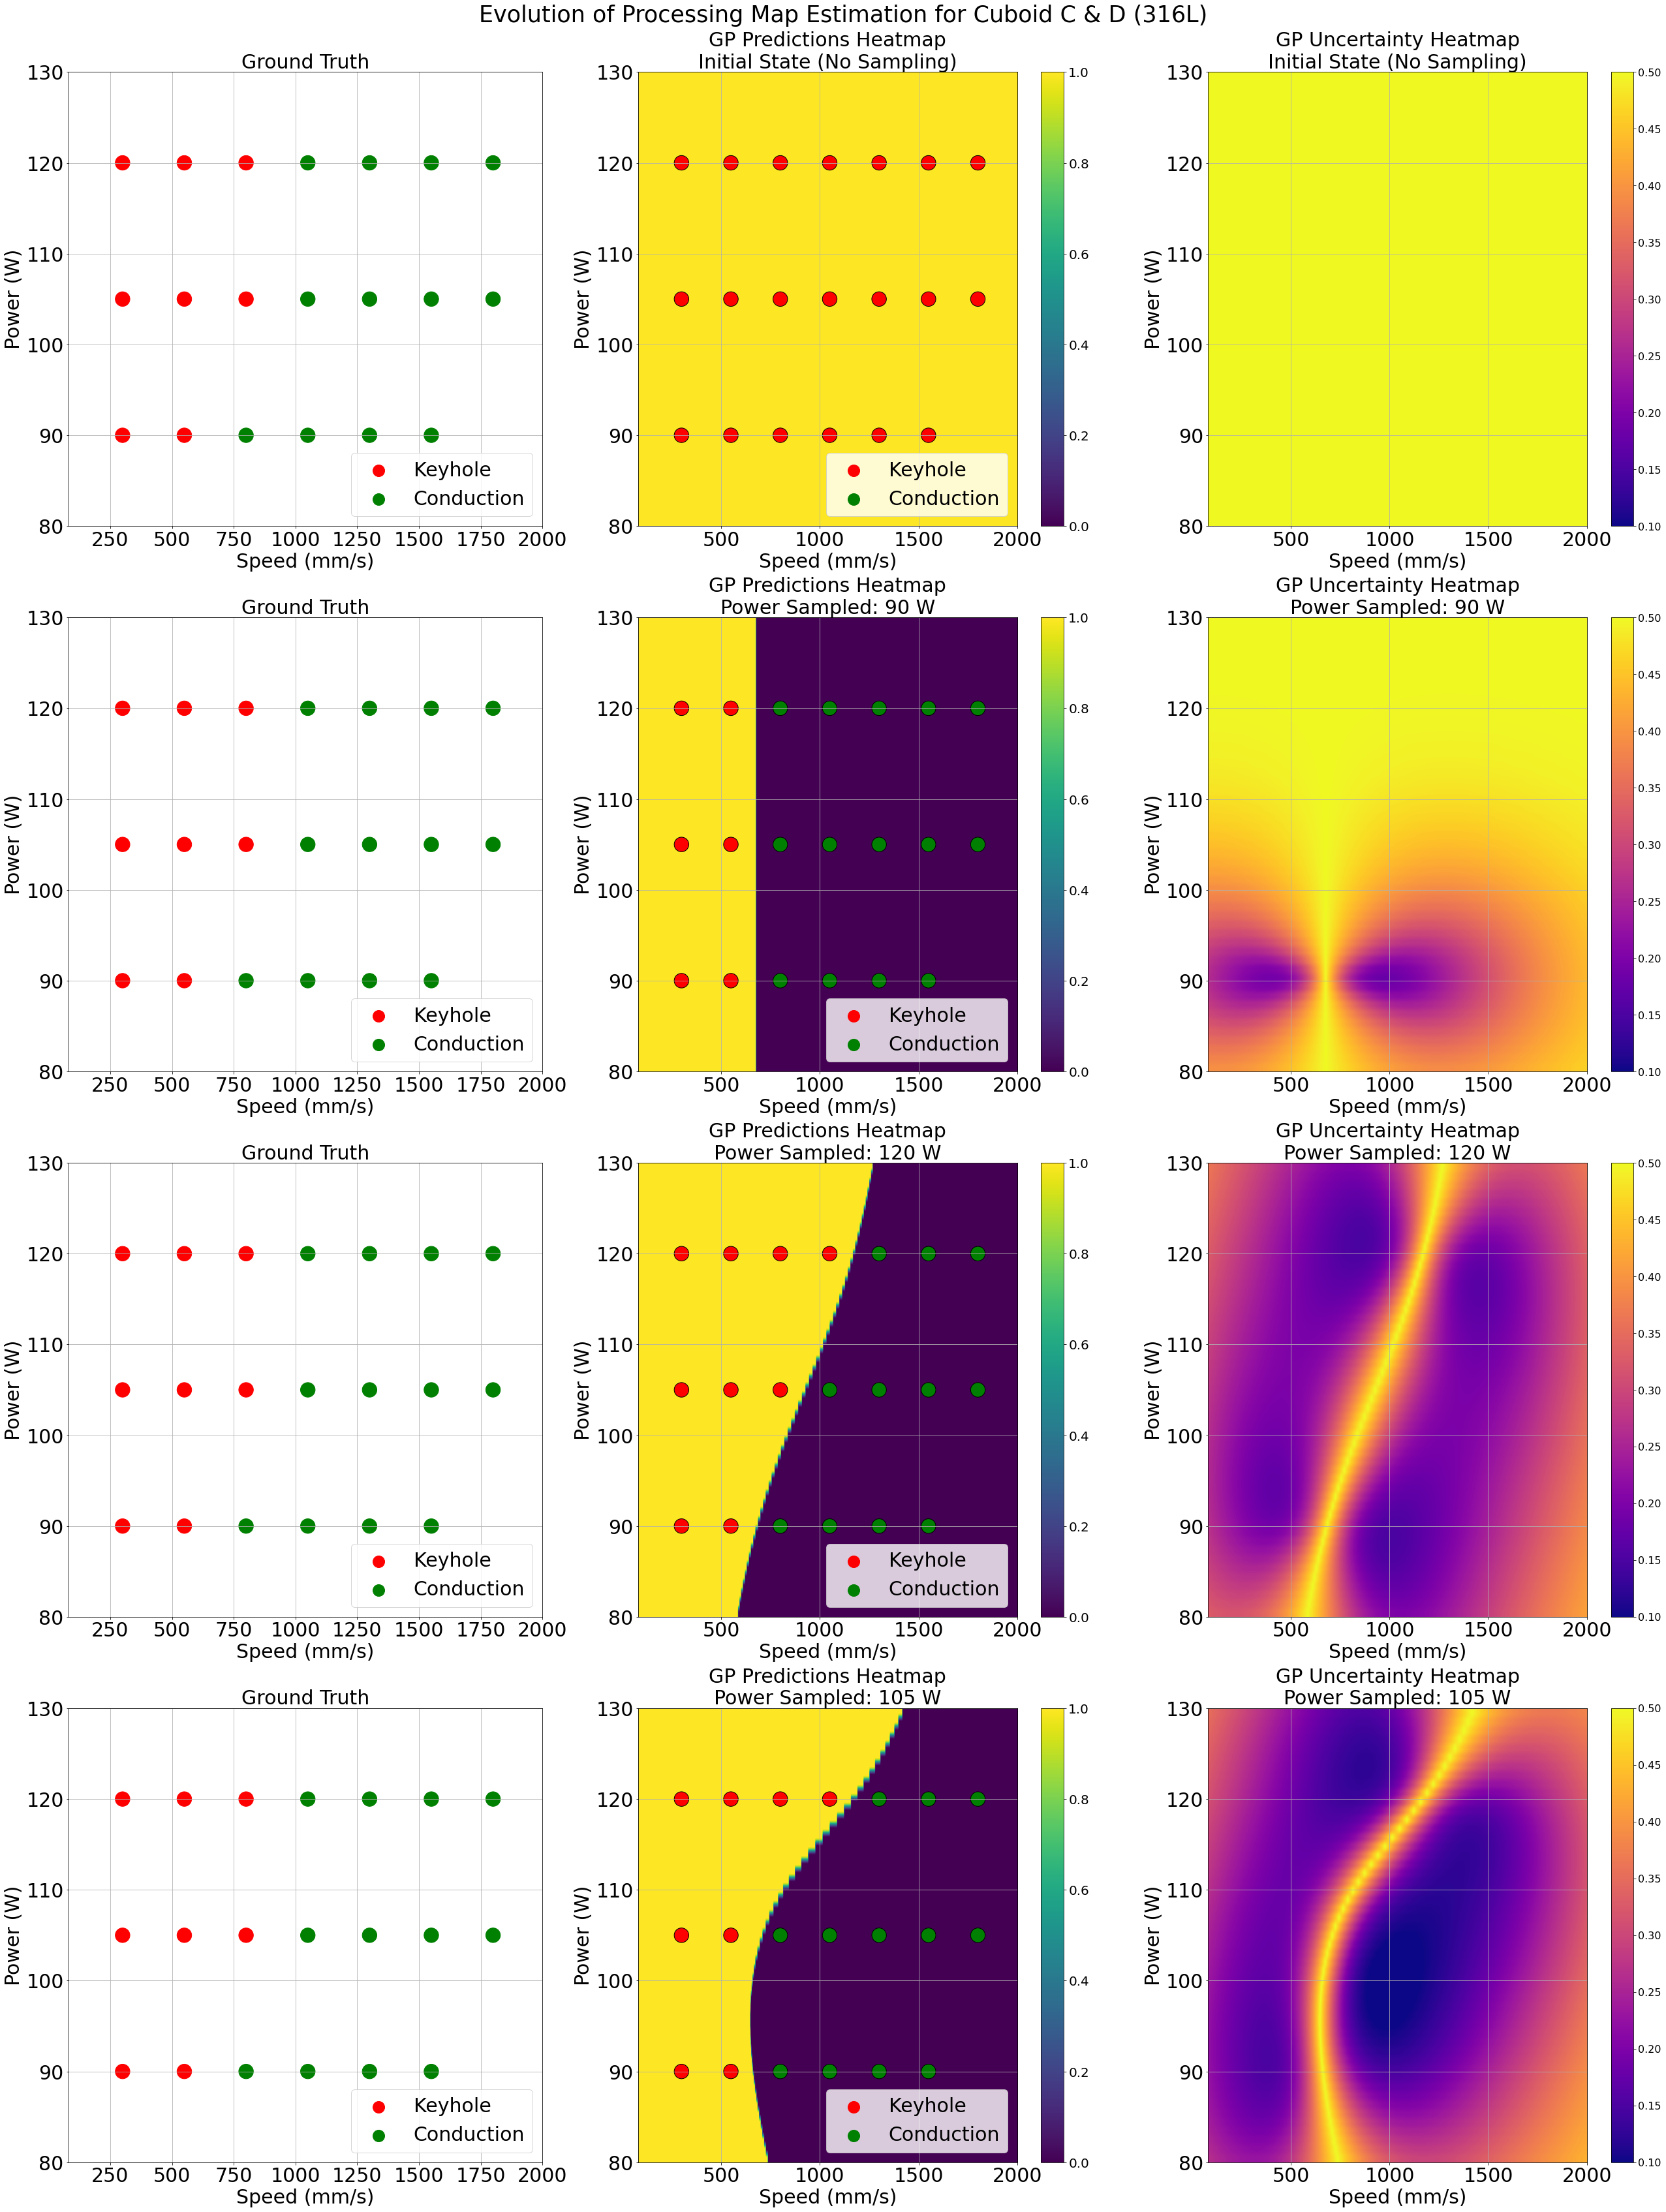

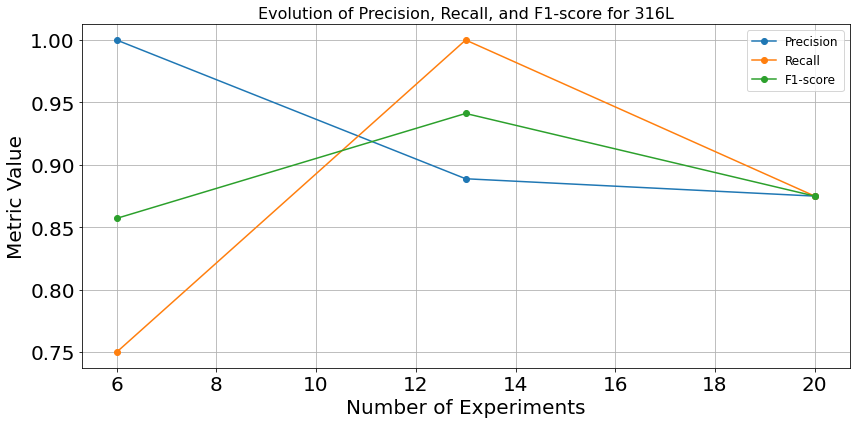

In [7]:
# Load the data
material = '316L'
cube_numbers = [5, 6]
cube_names = 'C & D'

active_learning(material, cube_numbers, cube_names)